# Тетрадка для проведения кластеризации

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np 
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from minisom import MiniSom

from sklearn import metrics 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import bcubed

import warnings
warnings.filterwarnings("ignore")

In [3]:
def split_scores(num_groups, df): #bcubed table
    df_sorted = df.sort_values(by='index')
    quantiles = pd.qcut(df_sorted['index'], q=num_groups, labels=False)
    df_sorted['group'] = quantiles
    df_sorted = df_sorted.reset_index(drop=True)
    data = df_sorted[['bank_name', 'group']].set_index('bank_name')
    data['group'] = data['group'].apply(lambda x: set([str(x)]))
    clusters = data.T.to_dict('records')[0]
    return clusters

def form_equal_dict(dict1, dict2):
    if len(dict1.keys()) >= len(dict2.keys()):
        bigger = dict1
        smaller = dict2
    else:
        smaller = dict1
        bigger = dict2

    bigger = {k: v for (k,v) in bigger.items() if k in smaller.keys()}
    return bigger, smaller

In [4]:
def find_similar_keys(list1, list2):
#     similar_keys = {}
    similar_keys = pd.DataFrame(columns = ['x_2023_bank_name', 'index_bank_name'])
    for idx, key2 in enumerate(list2):
        closest_match = difflib.get_close_matches(key2, list1, n=1)
        if closest_match:
            similar_keys.loc[idx] = [closest_match[0], key2]
#             similar_keys[key2] = closest_match[0]
                
    return similar_keys

In [17]:
def split_scores(num_groups, df=df_bcubed_table):
    df_sorted = df.sort_values(by='index')
    quantiles = pd.qcut(df_sorted['index'], q=num_groups, labels=False)
    df_sorted['group'] = quantiles
    df_sorted = df_sorted.reset_index(drop=True)
    data = df_sorted[['bank_name', 'group']].set_index('bank_name')
    data['group'] = data['group'].apply(lambda x: set([str(x)]))
    clusters = data.T.to_dict('records')[0]
    return clusters

In [4]:
# !pip install bcubed

## Проводим маппинг названий банков

In [78]:
find_similar_keys(x_2023['bank_name'], index_data['banks']).to_excel('df_similar_keys.xlsx', index= False)

In [83]:
df_mapping = pd.read_excel('df_similar_keys.xlsx', sheet_name= 'mapping')

In [85]:
df_mapping.head(2)

,x_2023_bank_name,index_bank_name
0,Сбербанк,Сбербанк
1,ВТБ,ВТБ


In [90]:
df_index2 = index_data.merge(df_mapping, how = 'inner', 
                             left_on = 'banks', right_on = 'index_bank_name')[['x_2023_bank_name', 'index']]

In [93]:
df_index2.head(5)

,x_2023_bank_name,index
0,Сбербанк,90.000000
1,ВТБ,84.165670
2,Альфа-Банк,76.659029
3,Газпромбанк,77.017086
4,Тинькофф Банк,67.381420


In [97]:
x_2023 = x_2023.merge(df_index2, how = 'left', 
                      left_on = 'bank_name', right_on = 'x_2023_bank_name').drop(columns = 'x_2023_bank_name')

In [101]:
x_2023.to_excel('x_2023_2.xlsx', index = False)

In [106]:
df_bcubed_table = x_2023[['bank_name', 'index']].dropna()

In [107]:
df_bcubed_table.to_excel('df_bcubed_table.xlsx', index = False)

In [ ]:
# Смотрим на правильность ответов в excel и убираем плохие совпадения

## Загружаем нужные данные:

In [6]:
df_bcubed_table = pd.read_excel('df_bcubed_table.xlsx')
x_2023 = pd.read_excel('full_dfs/x_2023.xlsx')
index_data = pd.read_excel('bank_index.xlsx')
x_2023_2 = pd.read_excel('x_2023_2.xlsx')

In [7]:
df_bcubed_table.head()

,bank_name,index
0,Сбербанк,90.000000
1,ВТБ,84.165670
2,Газпромбанк,77.017086
3,Альфа-Банк,76.659029
4,Россельхозбанк,74.921399


In [8]:
x_2023.describe()

,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
count,336.000000,230.000000,328.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,333.000000,339.000000,326.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,0.505829,1.374959,1.610101,0.026296,-0.364052,0.008651,0.321466,0.476693,0.667327,0.006176,0.137834,0.025814,0.214669,0.106797,0.345861,0.066227,0.240910,16.565817,0.053097,0.094395,0.032448
std,0.670366,1.300844,1.134924,0.056425,8.835744,0.069839,0.238185,0.230237,0.227530,0.063839,0.170910,0.059523,0.186865,0.153801,0.258393,0.313916,0.353005,2.265031,0.224559,0.292810,0.177450
min,0.000000,0.000000,0.000000,-0.248132,-162.453643,0.000000,0.000000,0.000000,0.000000,0.000000,0.001112,0.000000,0.000000,0.000000,0.000000,0.000000,-5.217186,11.597055,0.000000,0.000000,0.000000
25%,0.168500,0.667900,1.011600,0.008699,0.040116,0.000000,0.095208,0.337486,0.544326,0.000219,0.048470,0.007463,0.033504,0.002700,0.139650,0.000000,0.128559,14.817675,0.000000,0.000000,0.000000
50%,0.299250,0.975850,1.306350,0.018523,0.092746,0.000104,0.331125,0.528217,0.730677,0.000277,0.078463,0.014384,0.183898,0.037977,0.293845,0.000000,0.196721,16.389328,0.000000,0.000000,0.000000
75%,0.534800,1.634350,1.905350,0.034076,0.168815,0.000816,0.518282,0.646407,0.832468,0.000419,0.138108,0.028987,0.369075,0.149529,0.532911,0.027758,0.349801,17.998877,0.000000,0.000000,0.000000
max,5.683800,8.724800,9.709500,0.475582,2.384226,1.000000,0.929828,0.880495,0.988576,1.000000,0.975872,1.000000,0.747158,0.929790,0.981356,5.277712,0.975964,24.649107,1.000000,1.000000,1.000000


# K-means

In [9]:
X = x_2023.drop(columns = ['bank_name', 'log_TotalAssets'])
bank_names =x_2023['bank_name'] 

In [239]:
# силуэт [-1, 1] - чем ближе к 1, тем лучше разбиение
# davies bolduin - чем ближе к 0, тем лучше
# calinski_harabasz - чем выше, тем лучше

In [240]:
df_total_notes = pd.DataFrame() # таблица для сравнения метрик кластеризаций

In [241]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = True,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [242]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,False,2,True,tsne,20,0.009559,6712.203067,0.983040,0.666668,"[1.0, 0.0]"
2,K-means,False,3,True,tsne,20,0.634835,5249.818614,0.524426,0.467273,"[0.9, 0.1, 0.0]"
3,K-means,False,4,True,tsne,20,0.947918,4134.044130,0.335918,0.363199,"[0.7, 0.2, 0.1, 0.0]"
4,K-means,False,5,True,tsne,20,0.747803,3544.843072,0.428104,0.329426,"[0.8, 0.2, 0.0, 0.0, 0.0]"
5,K-means,False,6,True,tsne,20,1.028822,3216.462827,0.209037,0.265748,"[0.5, 0.3, 0.1, 0.0, 0.0, 0.0]"
6,K-means,False,7,True,tsne,20,0.916388,2970.105416,0.222764,0.250435,"[0.6, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0]"
7,K-means,False,8,True,tsne,20,1.023407,2766.758027,0.179330,0.243171,"[0.5, 0.3, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]"


In [243]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [244]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = True,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [245]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,True,tsne,20,2.138336,48.573612,0.185413,0.603862,"[0.6, 0.4]"
2,K-means,True,3,True,tsne,20,2.077253,39.547721,0.189483,0.462121,"[0.5, 0.3, 0.2]"
3,K-means,True,4,True,tsne,20,1.455166,41.260839,0.198946,0.414122,"[0.6, 0.3, 0.1, 0.0]"
4,K-means,True,5,True,tsne,20,1.331590,40.272518,0.175337,0.356151,"[0.5, 0.3, 0.2, 0.0, 0.0]"
5,K-means,True,6,True,tsne,20,1.305669,38.632740,0.214495,0.343786,"[0.5, 0.3, 0.1, 0.1, 0.0, 0.0]"
6,K-means,True,7,True,tsne,20,1.322970,39.003850,0.171507,0.354586,"[0.4, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0]"
7,K-means,True,8,True,tsne,20,1.363936,38.013308,0.150178,0.262481,"[0.4, 0.2, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0]"


In [246]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [247]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='pca', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()

In [248]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,False,pca,20,0.959991,224.166580,0.437336,0.611727,"[0.6, 0.4]"
2,K-means,True,3,False,pca,20,0.890379,218.440937,0.458852,0.471138,"[0.6, 0.2, 0.2]"
3,K-means,True,4,False,pca,20,0.690283,214.761786,0.457882,0.392868,"[0.6, 0.2, 0.2, 0.0]"
4,K-means,True,5,False,pca,20,0.743700,226.422001,0.350749,0.313713,"[0.4, 0.3, 0.2, 0.1, 0.0]"
5,K-means,True,6,False,pca,20,0.738285,231.284736,0.353350,0.272846,"[0.3, 0.2, 0.2, 0.2, 0.1, 0.0]"
6,K-means,True,7,False,pca,20,0.674524,249.918454,0.365322,0.260014,"[0.3, 0.2, 0.2, 0.2, 0.1, 0.0, 0.0]"
7,K-means,True,8,False,pca,20,0.726339,253.703124,0.359178,0.248433,"[0.3, 0.3, 0.2, 0.2, 0.1, 0.1, 0.0, 0.0]"


In [249]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [250]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=20 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,False,tsne,20,0.764339,483.868260,0.487582,0.570199,"[0.5, 0.5]"
2,K-means,True,3,False,tsne,20,0.995177,356.926903,0.345360,0.402339,"[0.4, 0.3, 0.3]"
3,K-means,True,4,False,tsne,20,0.931234,358.717275,0.385001,0.340038,"[0.3, 0.2, 0.2, 0.2]"
4,K-means,True,5,False,tsne,20,0.812659,319.528882,0.401550,0.322624,"[0.3, 0.2, 0.2, 0.2, 0.1]"
5,K-means,True,6,False,tsne,20,0.778829,359.736103,0.401398,0.292080,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.1]"
6,K-means,True,7,False,tsne,20,0.717520,406.721339,0.433868,0.256437,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1]"
7,K-means,True,8,False,tsne,20,0.759803,441.455809,0.429848,0.237768,"[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]"


In [251]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [252]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=10 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,False,tsne,10,1.021343,247.996033,0.375206,0.559450,"[0.6, 0.4]"
2,K-means,True,3,False,tsne,10,0.865394,298.938528,0.399242,0.410953,"[0.4, 0.3, 0.3]"
3,K-means,True,4,False,tsne,10,0.811224,312.677752,0.409782,0.347421,"[0.3, 0.3, 0.2, 0.2]"
4,K-means,True,5,False,tsne,10,0.783075,509.984293,0.440294,0.324893,"[0.3, 0.3, 0.2, 0.2, 0.1]"
5,K-means,True,6,False,tsne,10,0.760399,419.981219,0.438491,0.313276,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1]"
6,K-means,True,7,False,tsne,10,0.683098,488.425618,0.452000,0.284572,"[0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]"
7,K-means,True,8,False,tsne,10,0.716458,496.962502,0.442812,0.267412,"[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]"


In [253]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [254]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=30 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,False,tsne,30,0.899607,345.882834,0.425966,0.570000,"[0.5, 0.5]"
2,K-means,True,3,False,tsne,30,0.916222,338.992972,0.398776,0.382366,"[0.5, 0.3, 0.2]"
3,K-means,True,4,False,tsne,30,0.890575,313.391024,0.360325,0.330111,"[0.3, 0.3, 0.2, 0.2]"
4,K-means,True,5,False,tsne,30,0.861654,314.787798,0.367450,0.323307,"[0.2, 0.2, 0.2, 0.2, 0.1]"
5,K-means,True,6,False,tsne,30,0.795701,357.699921,0.417807,0.276564,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1]"
6,K-means,True,7,False,tsne,30,0.731011,369.187124,0.417000,0.275032,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1]"
7,K-means,True,8,False,tsne,30,0.811452,364.119875,0.389488,0.273024,"[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]"


In [255]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [256]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = True,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,True,2,False,tsne,40,0.931404,320.887904,0.416512,0.571721,"[0.5, 0.5]"
2,K-means,True,3,False,tsne,40,0.936624,342.198848,0.389598,0.393417,"[0.4, 0.3, 0.3]"
3,K-means,True,4,False,tsne,40,1.091339,339.206499,0.356270,0.369098,"[0.3, 0.3, 0.2, 0.2]"
4,K-means,True,5,False,tsne,40,0.792567,318.314075,0.398419,0.295984,"[0.3, 0.2, 0.2, 0.2, 0.1]"
5,K-means,True,6,False,tsne,40,0.776436,360.337976,0.403216,0.288681,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1]"
6,K-means,True,7,False,tsne,40,0.792028,339.732780,0.392045,0.277877,"[0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]"
7,K-means,True,8,False,tsne,40,0.729431,363.902014,0.399110,0.285944,"[0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.0]"


In [257]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [258]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='tsne', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,False,2,False,tsne,40,0.769315,474.282892,0.482237,0.501412,"[0.6, 0.4]"
2,K-means,False,3,False,tsne,40,1.006848,369.676721,0.365889,0.365894,"[0.4, 0.3, 0.3]"
3,K-means,False,4,False,tsne,40,0.905111,332.446773,0.364518,0.297624,"[0.3, 0.3, 0.2, 0.2]"
4,K-means,False,5,False,tsne,40,0.814076,347.574219,0.397360,0.274904,"[0.2, 0.2, 0.2, 0.2, 0.1]"
5,K-means,False,6,False,tsne,40,0.823486,353.253570,0.381368,0.251422,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1]"
6,K-means,False,7,False,tsne,40,0.764711,379.159543,0.410602,0.230674,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1]"
7,K-means,False,8,False,tsne,40,0.780583,375.592617,0.404254,0.244806,"[0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]"


In [259]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [260]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [2, 3, 4, 5, 6, 7, 8], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne='pca', #dimensional reduce with tsne or pca
                        clustering_before_dimreduce = False,
                          perplexity=40 #for tsne
                         )
k_means.k_means_clustering()
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,False,2,False,pca,40,0.006459,11125.933029,0.987789,0.666668,"[1.0, 0.0]"
2,K-means,False,3,False,pca,40,0.360485,13504.296772,0.691350,0.467273,"[0.9, 0.1, 0.0]"
3,K-means,False,4,False,pca,40,0.371134,14334.942741,0.617488,0.382802,"[0.8, 0.2, 0.0, 0.0]"
4,K-means,False,5,False,pca,40,0.462854,17442.356377,0.492069,0.288824,"[0.5, 0.3, 0.1, 0.0, 0.0]"
5,K-means,False,6,False,pca,40,0.486205,18987.729104,0.458635,0.263867,"[0.5, 0.3, 0.2, 0.1, 0.0, 0.0]"
6,K-means,False,7,False,pca,40,0.422269,20309.555927,0.457324,0.237350,"[0.4, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0]"
7,K-means,False,8,False,pca,40,0.424465,23581.999655,0.483223,0.238205,"[0.4, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0, 0.0]"


In [261]:
df_total_notes = pd.concat([df_total_notes, k_means.df_notes])

In [262]:
df_total_notes.loc[((df_total_notes['clustering_before_dimreduce'] == True) | 
                    (df_total_notes['pca_or_tsne'] == 'pca')), 'perplexity'] = None

In [263]:
df_total_notes.to_excel('df_kmeans_result.xlsx', index = False) # сохраняем промужуточный результат

# DBSCAN

`X1` - в данных заполнены пропуски с помощью KNN

In [10]:
imputer = KNNImputer(n_neighbors=3, missing_values = np.nan, weights = 'distance')
X1 = imputer.fit_transform(X)

### данные не шкалированы

In [132]:
def draw_anomaly_plot(embeds, eps = 0.1, eps_grow=0.01):
    # для начала считаем все наблюдения аномальными
    outlier_percentage = 1.

    num_clusters = []
    anomaly_percentage = []

    # берем маленький эпсилон и начинаем увеличивать
    eps_history = [eps]

    while outlier_percentage > 0.1:
        model = DBSCAN(eps=eps, min_samples=3).fit(embeds)

        labels = model.labels_
        num_clusters.append(len(np.unique(labels))-1)
        labels = np.array([1 if label == -1 else 0 for label in labels])

        # считаем текущий процент "шума"
        outlier_percentage = sum(labels==1) / len(labels)
        eps += eps_grow
        eps_history.append(eps)
        anomaly_percentage.append(outlier_percentage)


    iterations = eps_history[:-1]
    fig, ax1 = plt.subplots(figsize=(8,5))
    color = 'tab:red'
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Number of clusters', color=color)
    ax1.plot(iterations, num_clusters, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

    color = 'tab:blue'
    ax2.set_ylabel('Anomaly %', color=color)
    ax2.plot(iterations, anomaly_percentage, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

Рисуем график для понимания tradeoff количества кластеров и аномалий:

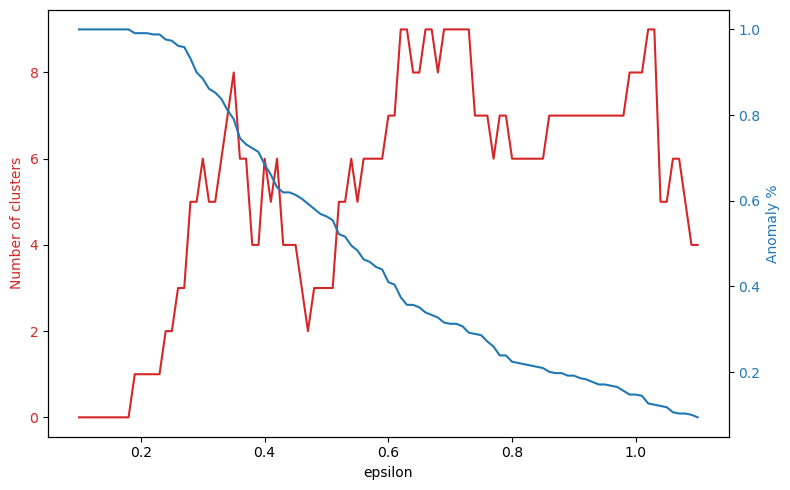

In [135]:
draw_anomaly_plot(X1, eps = 0.1,  eps_grow=0.01)

In [264]:
eps_list = [0.2 + 0.01 * x for x in range(100)]

df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'pca_or_tsne','perplexity',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])
for epsilon in eps_list:
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    clustering = dbscan.fit(X1)
    labels = clustering.labels_
    n_clusters=len(set(labels))- (1 if -1 in labels else 0)
    
    silhouette_score = metrics.silhouette_score(X1, labels)
    ch_score = metrics.calinski_harabasz_score(X1, labels)
    db_score = metrics.davies_bouldin_score(X1, labels)

    df_st['labels'] = labels
#     print(df_st['labels'].value_counts().reset_index())
#     print('============================================')
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
    
    prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))

    df_notes.loc[len(df_notes)+1] = ['DBSCAN', False, n_clusters, True, None, None, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]

In [266]:
df_total_notes = pd.concat([df_total_notes, df_notes])

### теперь шкалируем данные перед кластеризацией

In [11]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X1)

`X2` - в данных заполнены пропуски с помощью KNN, проведено шкалирование $z = \frac{x-\mu}{\sigma}$

График для шкалированных данных:

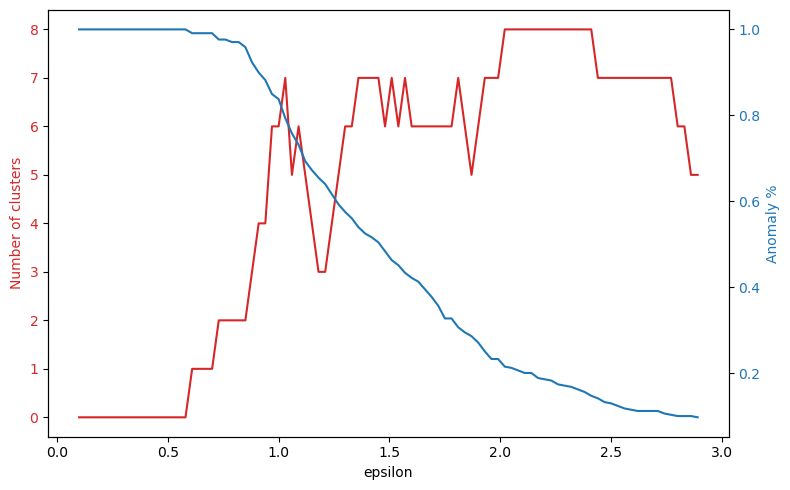

In [204]:
draw_anomaly_plot(X2, eps = 0.1,  eps_grow=0.03)

In [267]:
eps_list = [0.6 + 0.03 * x for x in range(90)]

df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'pca_or_tsne','perplexity',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])
for epsilon in eps_list:
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    clustering = dbscan.fit(X2)
    labels = clustering.labels_
    n_clusters=len(set(labels))- (1 if -1 in labels else 0)
    
    silhouette_score = metrics.silhouette_score(X2, labels)
    ch_score = metrics.calinski_harabasz_score(X2, labels)
    db_score = metrics.davies_bouldin_score(X2, labels)

    df_st['labels'] = labels
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
    
    prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))
    
    df_notes.loc[len(df_notes)+1] = ['DBSCAN', True, n_clusters, True, None, None, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]
    

In [268]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [269]:
df_total_notes.to_excel('df_dbscan_result.xlsx', index = False)

# FCM

In [13]:
# !pip install scikit-fuzzy

In [65]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## без шкалирования

In [270]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'm',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])

for c in [2, 3, 4, 5, 6, 7, 8]:
    for m in [2 + 10 * x for x in range(10)]:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = X1.T,
                            c = c,
                            m = m,
                            error = 0.01,
                            maxiter = 1000,
                            metric='euclidean',
                            init=None,
                            seed=126)

        labels = np.argmax(u, axis=0)
        silhouette_score = metrics.silhouette_score(X1, labels)
        ch_score = metrics.calinski_harabasz_score(X1, labels)
        db_score = metrics.davies_bouldin_score(X1, labels)

        df_st['labels'] = labels
        df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
        df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
        clusters = df1.T.to_dict('records')[1]

        y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
        precision_bcubed = bcubed.precision(y_pred, y_true)
        recall_bcubed = bcubed.recall(y_pred, y_true)
        fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
        
        prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))
        

        df_notes.loc[len(df_notes)+1] = ['fuzzy C-means', False, c, True, m, 
                                                           db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]    

In [276]:
df_total_notes = pd.concat([df_total_notes, df_notes])

## с шкалированием

In [279]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'm',
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])

for c in [2, 3, 4, 5, 6, 7, 8]:
    for m in [2 + 10 * x for x in range(10)]:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data = X2.T,
                            c = c,
                            m = m,
                            error = 0.01,
                            maxiter = 1000,
                            metric='euclidean',
                            init=None,
                            seed=126)

        labels = np.argmax(u, axis=0)
        silhouette_score = metrics.silhouette_score(X2, labels)
        ch_score = metrics.calinski_harabasz_score(X2, labels)
        db_score = metrics.davies_bouldin_score(X2, labels)

        df_st['labels'] = labels
        df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
        df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
        clusters = df1.T.to_dict('records')[1]

        y_true, y_pred = form_equal_dict(split_scores(n_clusters, df = df_bcubed_table), clusters)
        precision_bcubed = bcubed.precision(y_pred, y_true)
        recall_bcubed = bcubed.recall(y_pred, y_true)
        fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
        
        prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))

        df_notes.loc[len(df_notes)+1] = ['fuzzy C-means', True, c, True, m, 
                                                           db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]    

In [281]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [282]:
df_total_notes.to_excel('df_fcm_result.xlsx', index = False)

# Спектральная кластеризация

In [21]:
from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph

n_cluster = [2,3,4,5,6,7,8]

def draw_eigh(embeds, n):
    spectr = SpectralClustering(n_clusters=n, n_components=n, random_state=42)
    spectr.fit(embeds)
    L = csgraph.laplacian(spectr.affinity_matrix_)
    values, vectors = np.linalg.eigh(L)
    sns.lineplot(sorted(values[:10]))
    plt.plot()
    plt.ylabel('Eigenvalues')
    plt.xlabel('Numer of vectors')

def calc_methods_spectral(embeds, emb_alg, transform, averaging, notes):
    for n in tqdm(n_cluster):
        spectr = SpectralClustering(n_clusters=n, n_components=n)
        bank_cluster, embed_labels = clustering_bank(embeds, spectr, averaging)
        db, ch, ss, bc = calc_metrics(embeds, embed_labels, split_scores(n), bank_cluster)
        notes.loc[len(notes)+1] = [emb_alg, 'spectr', transform, n, averaging, db, ch, ss, bc]

Рисуем график собственных значений векторов:

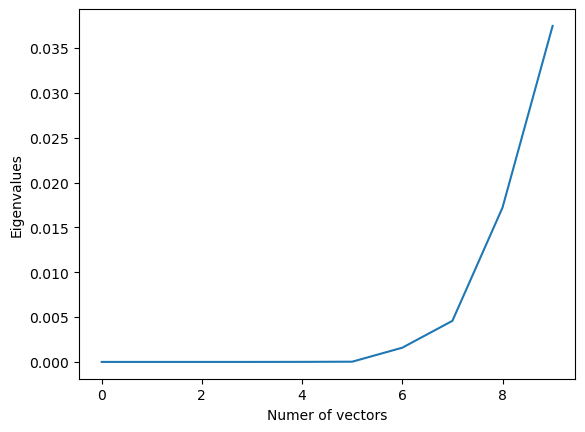

In [69]:
draw_eigh(X1, n=6)

In [ ]:
# не работает для масштабированной выборки

In [291]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])

n_clusters_list = [2,3,4,5,6,7,8]
for n in n_clusters_list:
    spectr = SpectralClustering(n_clusters=n, n_components=6)
    spectr.fit(X1)
    labels = spectr.labels_
    
    silhouette_score = metrics.silhouette_score(X1, labels)
    ch_score = metrics.calinski_harabasz_score(X1, labels)
    db_score = metrics.davies_bouldin_score(X1, labels)
    
    df_st['labels'] = labels
#     print(df_st['labels'].value_counts().reset_index())
#     print('============================================')
    df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
    df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
    clusters = df1.T.to_dict('records')[1]

    y_true, y_pred = form_equal_dict(split_scores(n, df = df_bcubed_table), clusters)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
    
    prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))

    df_notes.loc[len(df_notes)+1] = ['Spectral', False, n, True, 
                                                       db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]

In [293]:
df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,Spectral,False,2,True,0.513711,3.169033,0.673626,0.666676,"[1.0, 0.0]"
2,Spectral,False,3,True,0.498919,1.940123,0.527189,0.499030,"[1.0, 0.0, 0.0]"
3,Spectral,False,4,True,0.725861,1.428197,0.318566,0.413807,"[1.0, 0.0, 0.0, 0.0]"
4,Spectral,False,5,True,0.868384,1.530925,0.300724,0.348722,"[0.9, 0.0, 0.0, 0.0, 0.0]"
5,Spectral,False,6,True,0.835800,1.330000,0.281982,0.304877,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,Spectral,False,7,True,0.802632,1.242802,0.279251,0.282241,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,Spectral,False,8,True,0.798423,1.178620,0.272720,0.278309,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [295]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [296]:
df_total_notes.to_excel('df_spectral_result.xlsx', index = False)

# SOM

## без шкалирования

In [299]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'sigma_elast', 'learnig_rate', 
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])
n_neurons = 1
n_clusters_list = [2,3,4,5,6,7,8]
sigmas = [1, 2, 5, 10, 50]
lrs_list = [0.5, 1]

for m_neurons in tqdm(n_clusters_list):
    for sigma in sigmas:
        for lr in lrs_list:
            som = MiniSom(n_neurons, m_neurons, X1.shape[1], sigma=sigma, learning_rate=lr,  #sigma - эластичность сети
                      neighborhood_function='gaussian', random_seed=132, topology='hexagonal')
            # som.pca_weights_init(X1)
            som.train(X1, num_iteration = 100, verbose=False, use_epochs=True, random_order = True)
            winner_coordinates = np.array([som.winner(x) for x in X1]).T
            labels = np.ravel_multi_index(winner_coordinates, (n_neurons, m_neurons))

            silhouette_score = metrics.silhouette_score(X1, labels)
            ch_score = metrics.calinski_harabasz_score(X1, labels)
            db_score = metrics.davies_bouldin_score(X1, labels)

            df_st['labels'] = labels
            df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
            df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
            clusters = df1.T.to_dict('records')[1]

            y_true, y_pred = form_equal_dict(split_scores(n, df = df_bcubed_table), clusters)
            precision_bcubed = bcubed.precision(y_pred, y_true)
            recall_bcubed = bcubed.recall(y_pred, y_true)
            fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
            
            prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))

            df_notes.loc[len(df_notes)+1] = ['SOM', False, m_neurons, True, sigma, lr, 
                                                               db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]

  0%|          | 0/7 [00:00<?, ?it/s]

In [300]:
df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,sigma_elast,learnig_rate,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,SOM,False,2,True,1,0.5,0.009559,6712.203067,0.983040,0.233834,"[1.0, 0.0]"
2,SOM,False,2,True,1,1.0,0.009559,6712.203067,0.983040,0.233834,"[1.0, 0.0]"
3,SOM,False,2,True,2,0.5,0.962709,340.281942,0.964514,0.233834,"[1.0, 0.0]"
4,SOM,False,2,True,2,1.0,1.824415,15.036138,0.689931,0.222151,"[0.9, 0.1]"
5,SOM,False,2,True,5,0.5,1.790093,12.789635,0.633261,0.224110,"[0.9, 0.1]"
6,SOM,False,2,True,5,1.0,1.077330,5.700802,0.441331,0.218334,"[0.9, 0.1]"
7,SOM,False,2,True,10,0.5,1.790093,12.789635,0.633261,0.224110,"[0.9, 0.1]"
8,SOM,False,2,True,10,1.0,1.077330,5.700802,0.441331,0.218334,"[0.9, 0.1]"
9,SOM,False,2,True,50,0.5,1.790093,12.789635,0.633261,0.224110,"[0.9, 0.1]"
10,SOM,False,2,True,50,1.0,1.077330,5.700802,0.441331,0.218334,"[0.9, 0.1]"


In [301]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [302]:
df_total_notes.to_excel('df_som1_result.xlsx', index = False)

## после шкалирования

In [303]:
df_st = x_2023[['bank_name']]
df_notes = pd.DataFrame(columns=['clusterng', 'scaling', 'n_cluster', 'clustering_before_dimreduce', 'sigma_elast', 'learnig_rate', 
                                              'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed', 'prc_distributed'])
n_neurons = 1
n_clusters_list = [2,3,4,5,6,7,8]
sigmas = [1, 2, 5, 10, 50]
lrs_list = [0.5, 1]

for m_neurons in tqdm(n_clusters_list):
    for sigma in sigmas:
        for lr in lrs_list:
            som = MiniSom(n_neurons, m_neurons, X2.shape[1], sigma=sigma, learning_rate=lr,  #sigma - эластичность сети
                      neighborhood_function='gaussian', random_seed=132, topology='hexagonal')
            # som.pca_weights_init(X1)
            som.train(X2, num_iteration = 100, verbose=False, use_epochs=True, random_order = True)
            winner_coordinates = np.array([som.winner(x) for x in X1]).T
            labels = np.ravel_multi_index(winner_coordinates, (n_neurons, m_neurons))

            silhouette_score = metrics.silhouette_score(X2, labels)
            ch_score = metrics.calinski_harabasz_score(X2, labels)
            db_score = metrics.davies_bouldin_score(X2, labels)

            df_st['labels'] = labels
            df1 = df_st[['bank_name', 'labels']].set_index('bank_name')
            df1['group'] = df1['labels'].apply(lambda x: set([str(x)]))
            clusters = df1.T.to_dict('records')[1]

            y_true, y_pred = form_equal_dict(split_scores(n, df = df_bcubed_table), clusters)
            precision_bcubed = bcubed.precision(y_pred, y_true)
            recall_bcubed = bcubed.recall(y_pred, y_true)
            fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)
            
            prc_list = list(np.round(df_st['labels'].value_counts() / df_st.shape[0], decimals=1))

            df_notes.loc[len(df_notes)+1] = ['SOM', True, m_neurons, True, sigma, lr, 
                                                               db_score, ch_score, silhouette_score, fscore_bcubed, prc_list]

  0%|          | 0/7 [00:00<?, ?it/s]

In [306]:
df_total_notes = pd.concat([df_total_notes, df_notes])

In [307]:
df_total_notes.to_excel('df_som2_result.xlsx', index = False)

Пример визуализации SOM:

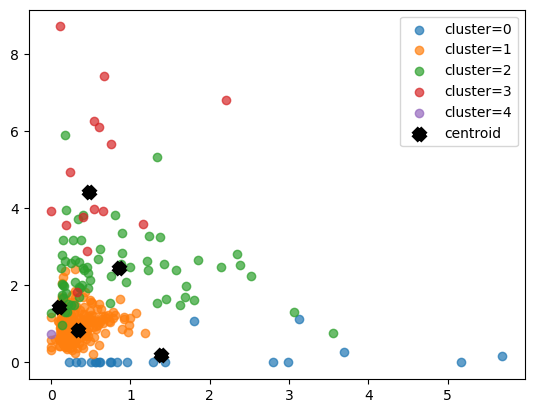

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(labels):
    plt.scatter(X1[labels == c, 0],
                X1[labels == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=20, linewidths=10, color='k', label='centroid')
plt.legend();

# Анализ кластеров

In [140]:
# tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5)
# components = tsne.fit_transform(X1)

In [149]:
# fig = px.scatter(components, x=0, y=1, color=cluster_index)
# fig.update_layout(title=f'Number of clusters = {n}')
# fig.show()

In [410]:
def plot_metric_distr(df_total_notes, metric, num_clusters):
    plt.figure(figsize=(22,26))
    for idx, method in enumerate(df_total_notes['clusterng'].unique()):
        plt.subplot(4,2,idx+1)
        df = df_total_notes[(df_total_notes['clusterng'] == method) & (df_total_notes['n_cluster'].isin(num_clusters))]
        sns.kdeplot(x= df[metric], shade=True, hue = df['n_cluster'], palette = 'bright')

        plt.title(method, fontsize=24)
        plt.xlabel(' ')
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)

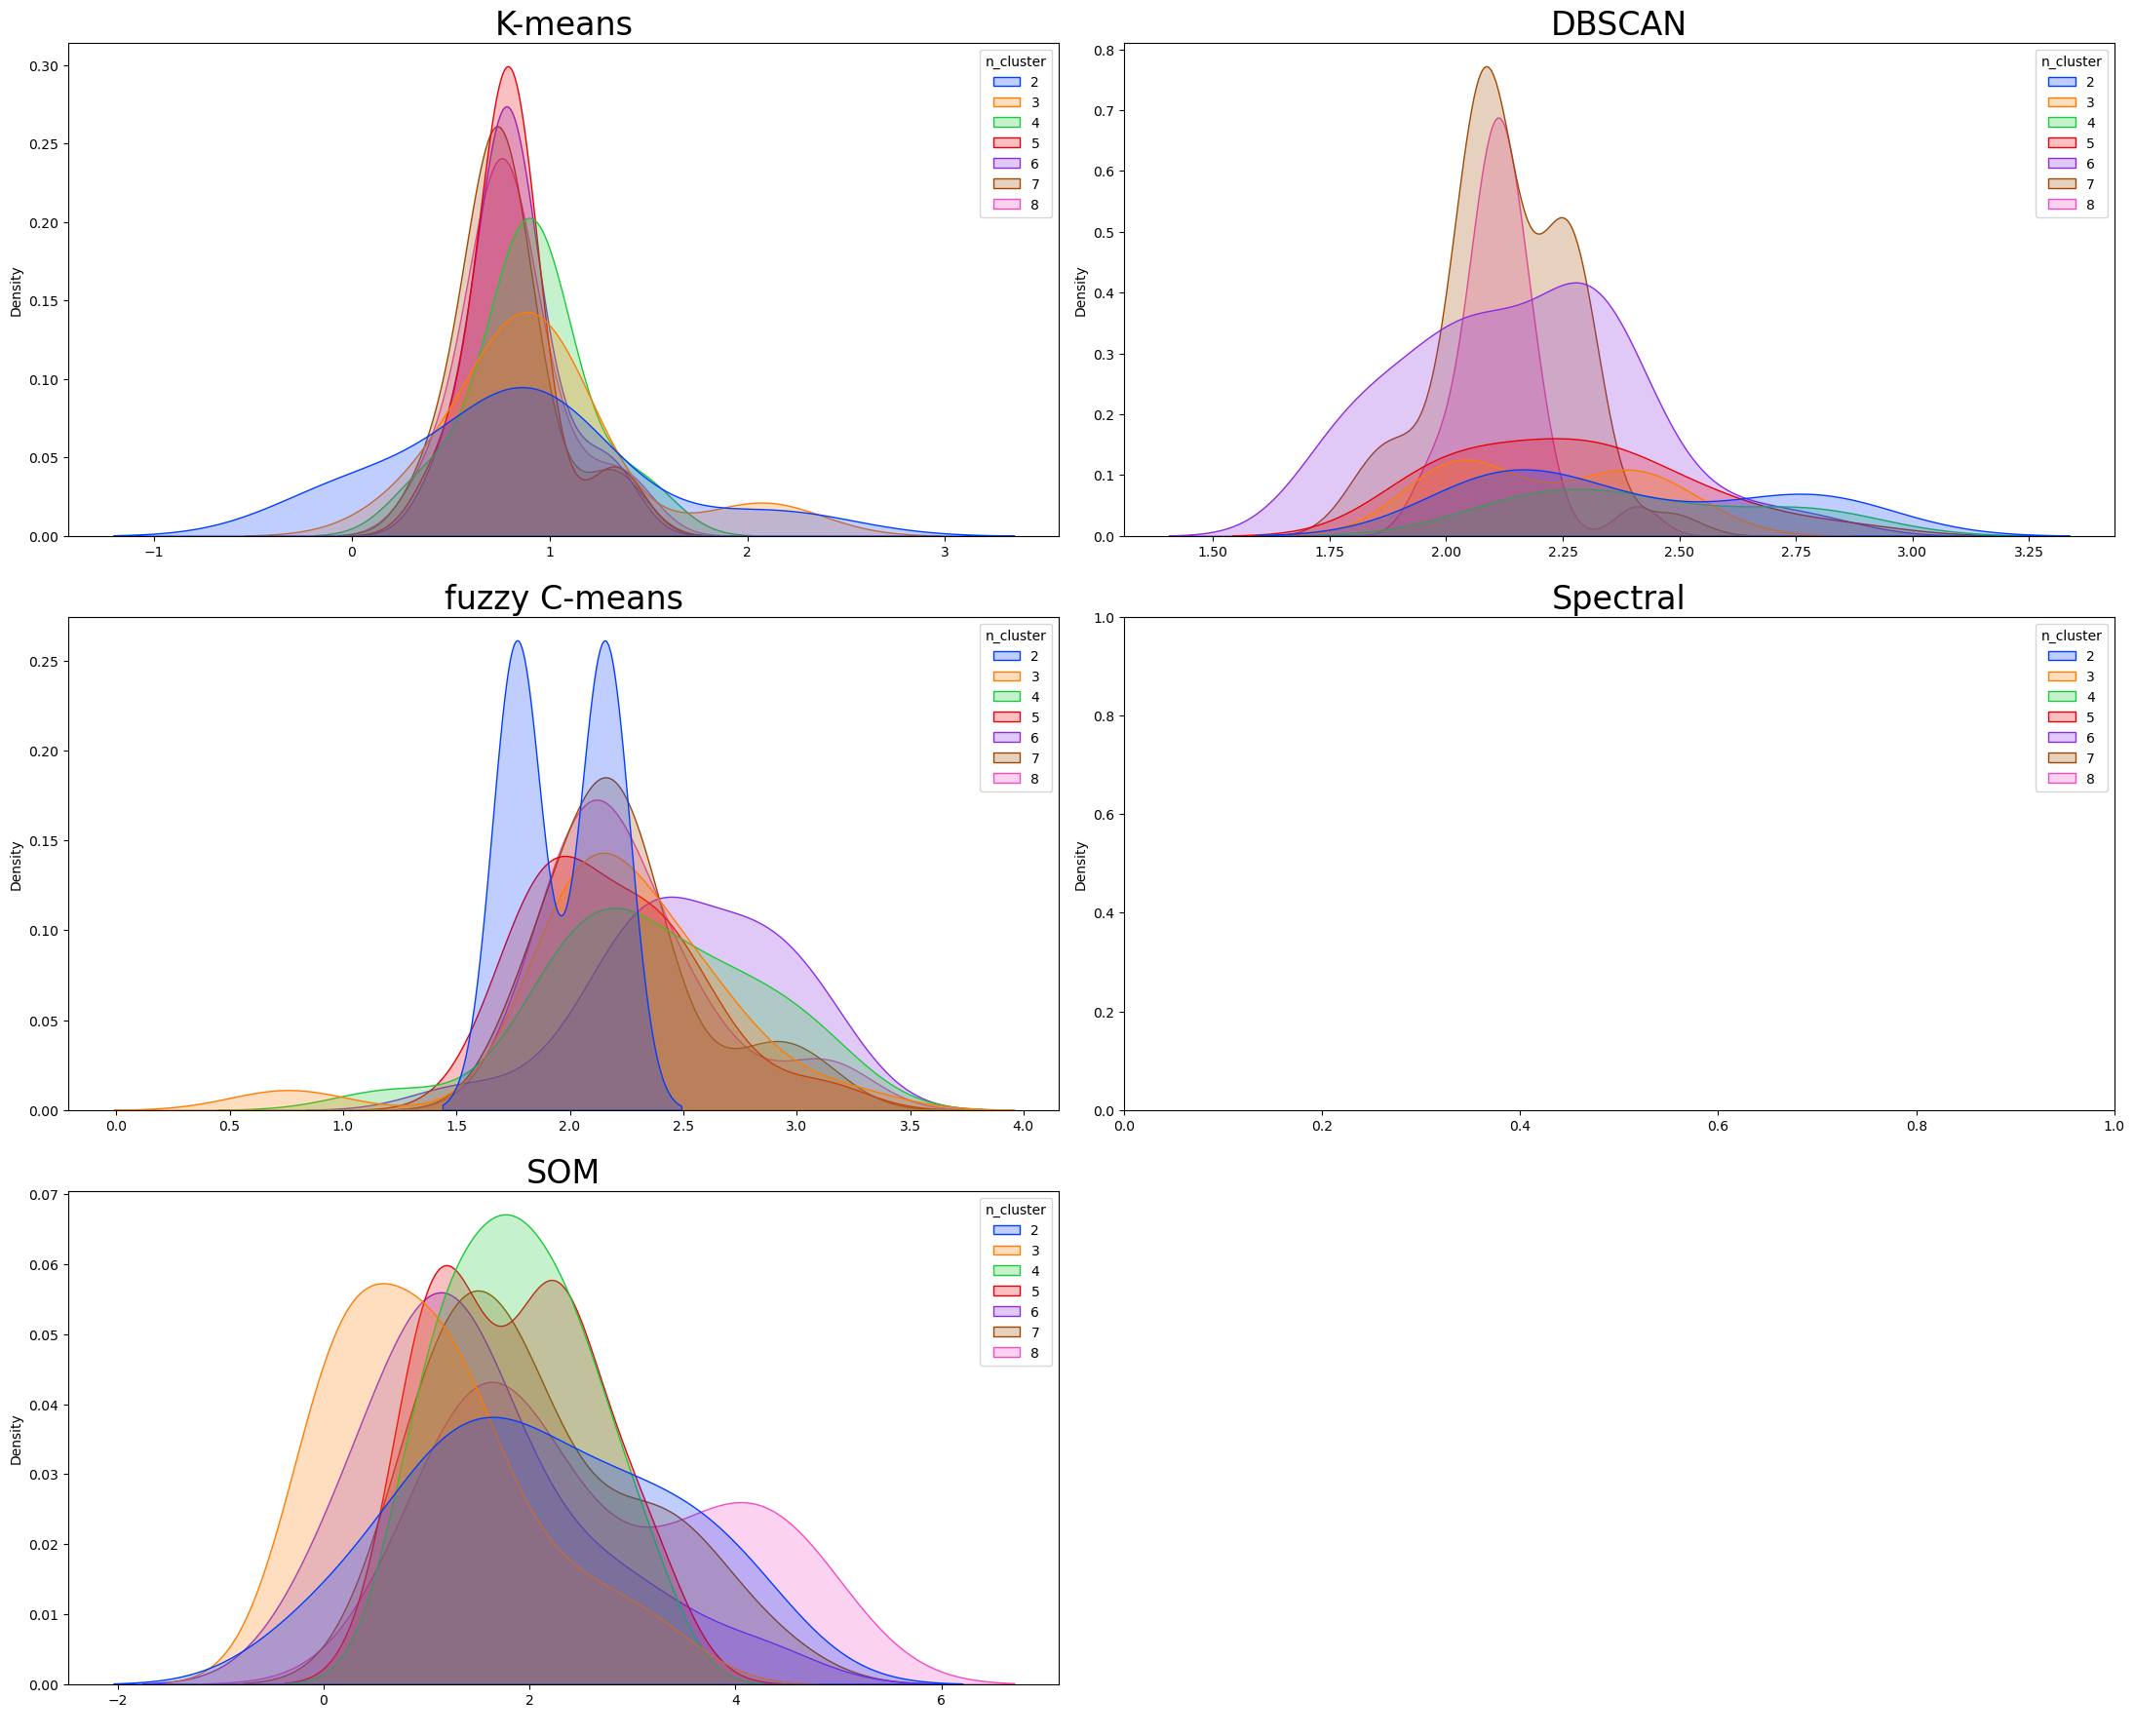

In [420]:
plot_metric_distr(df_total_notes, 'davies_bouldin', num_clusters = [2,3,4,5,6,7,8]) #[2,3,4,5,6,7,8]

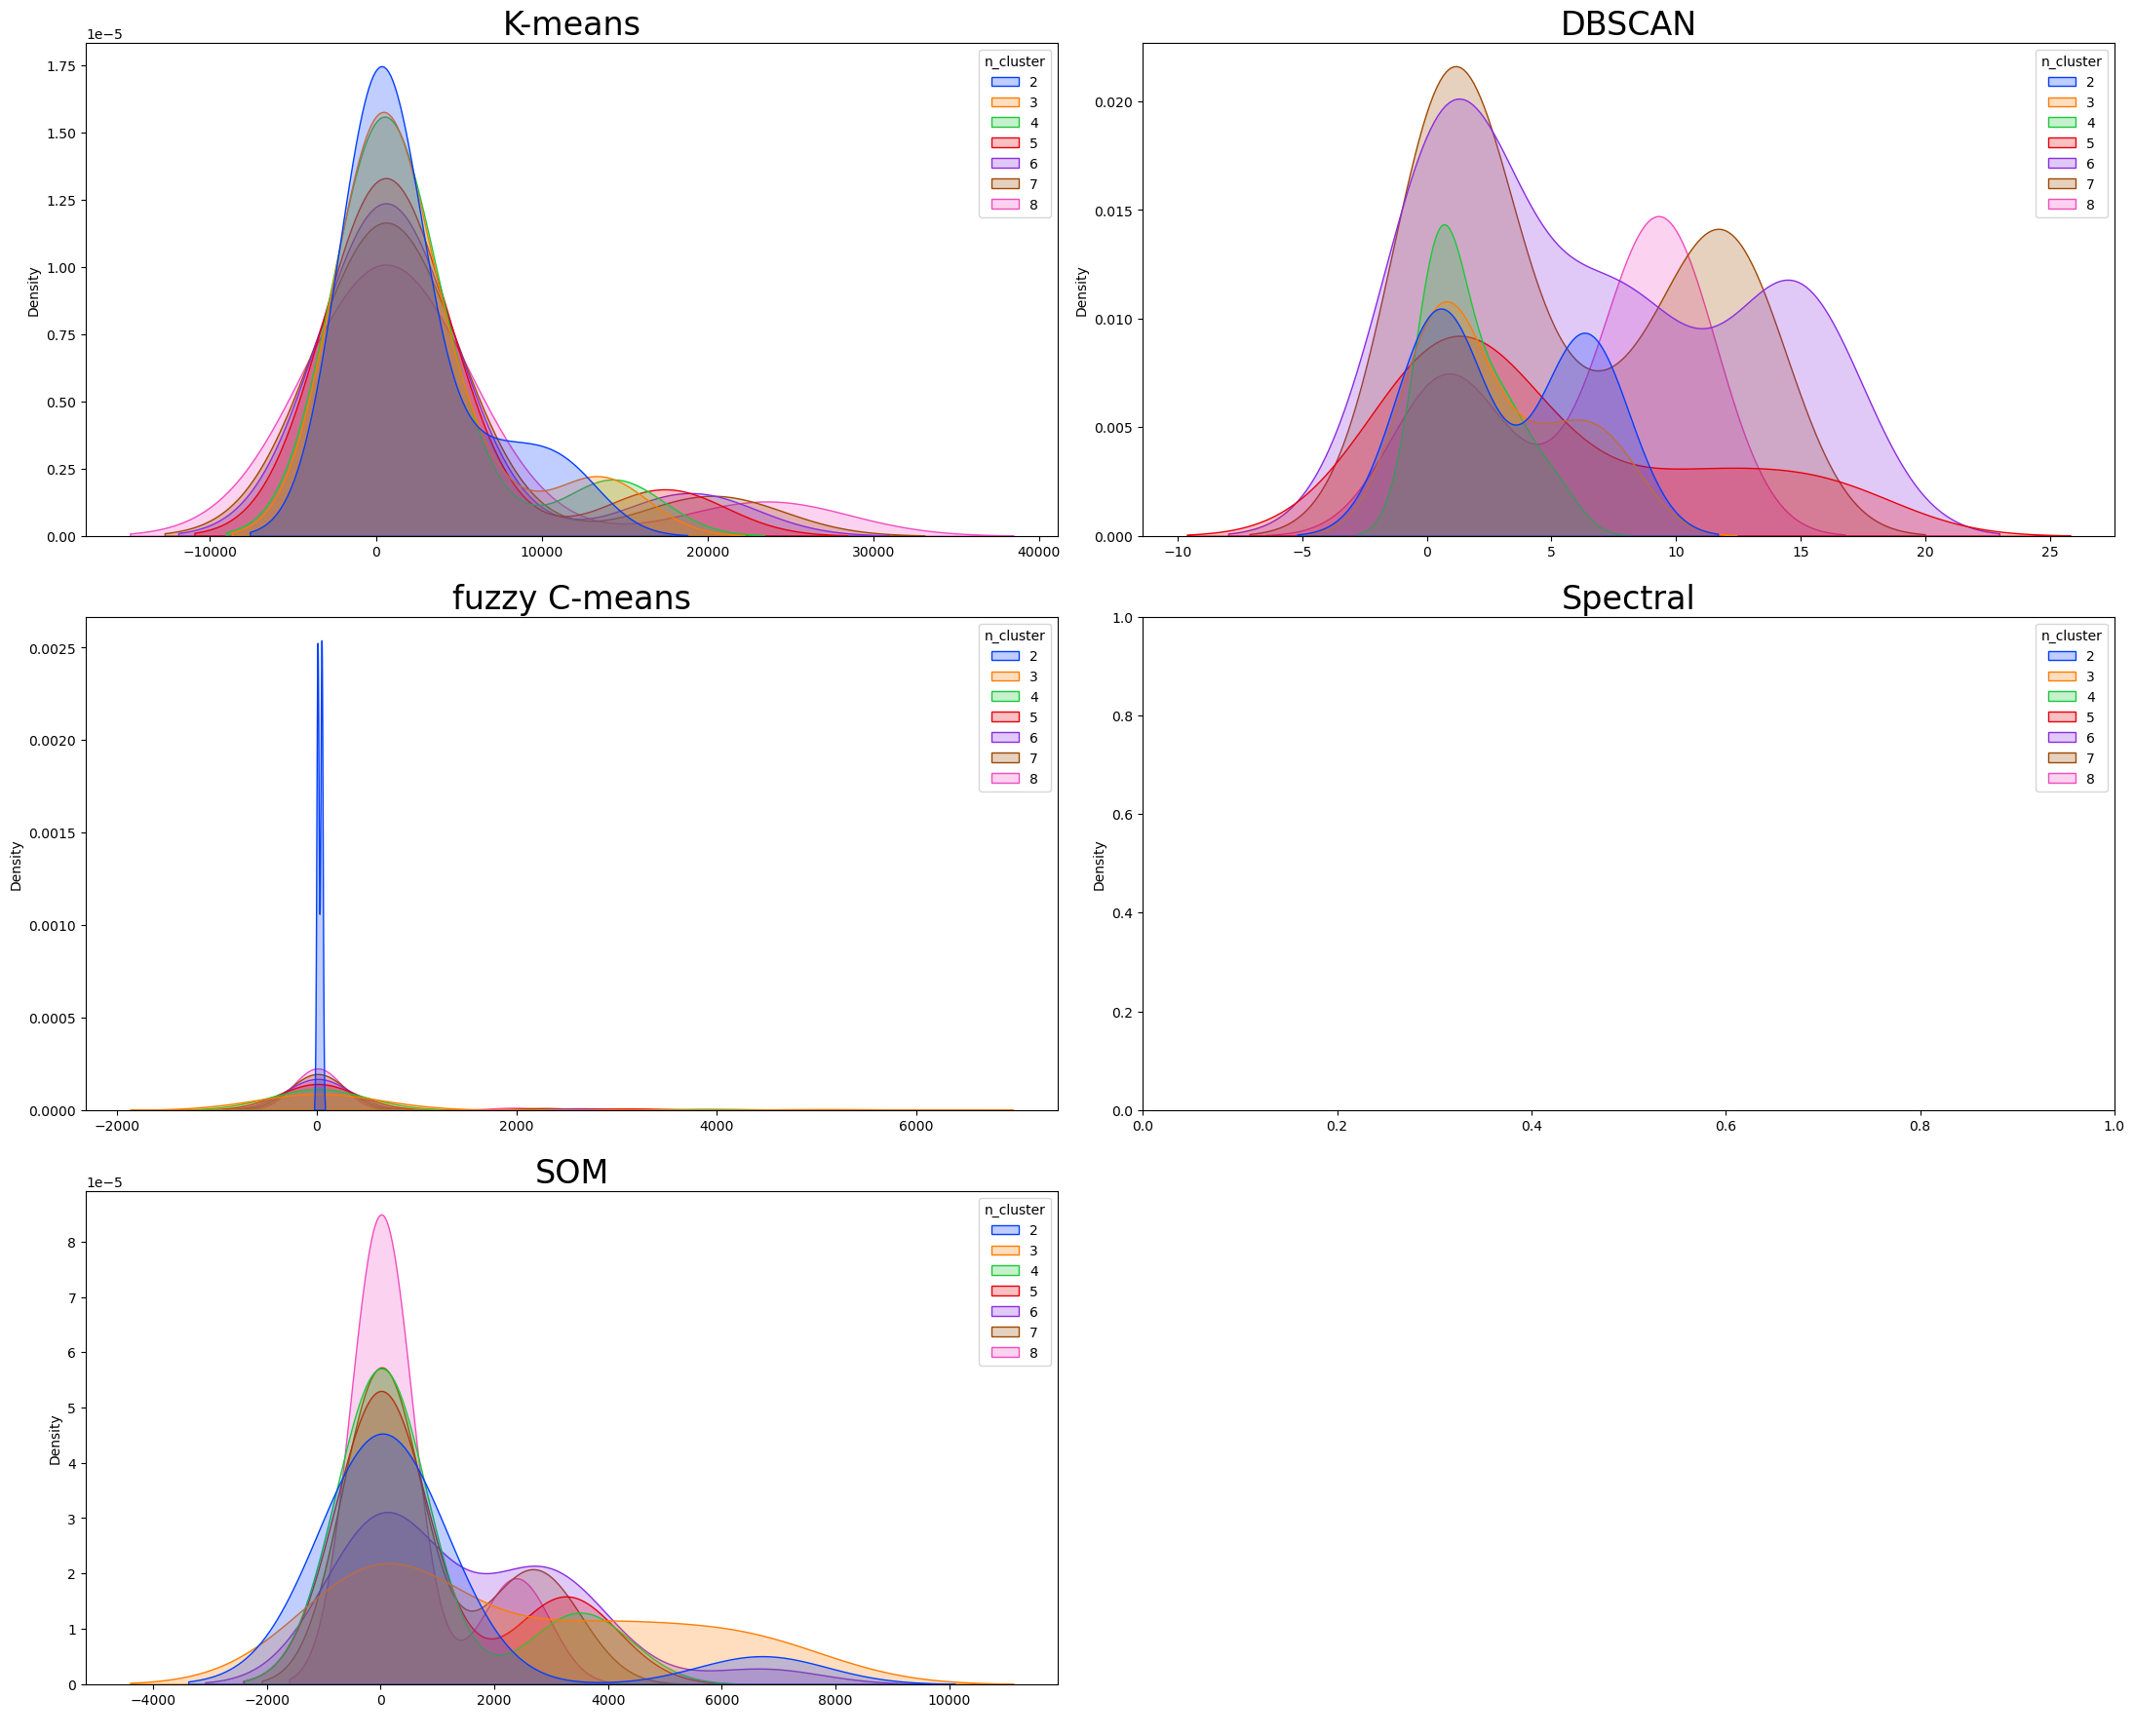

In [421]:
plot_metric_distr(df_total_notes, 'calinski_harabasz_score', num_clusters = [2,3,4,5,6,7,8])

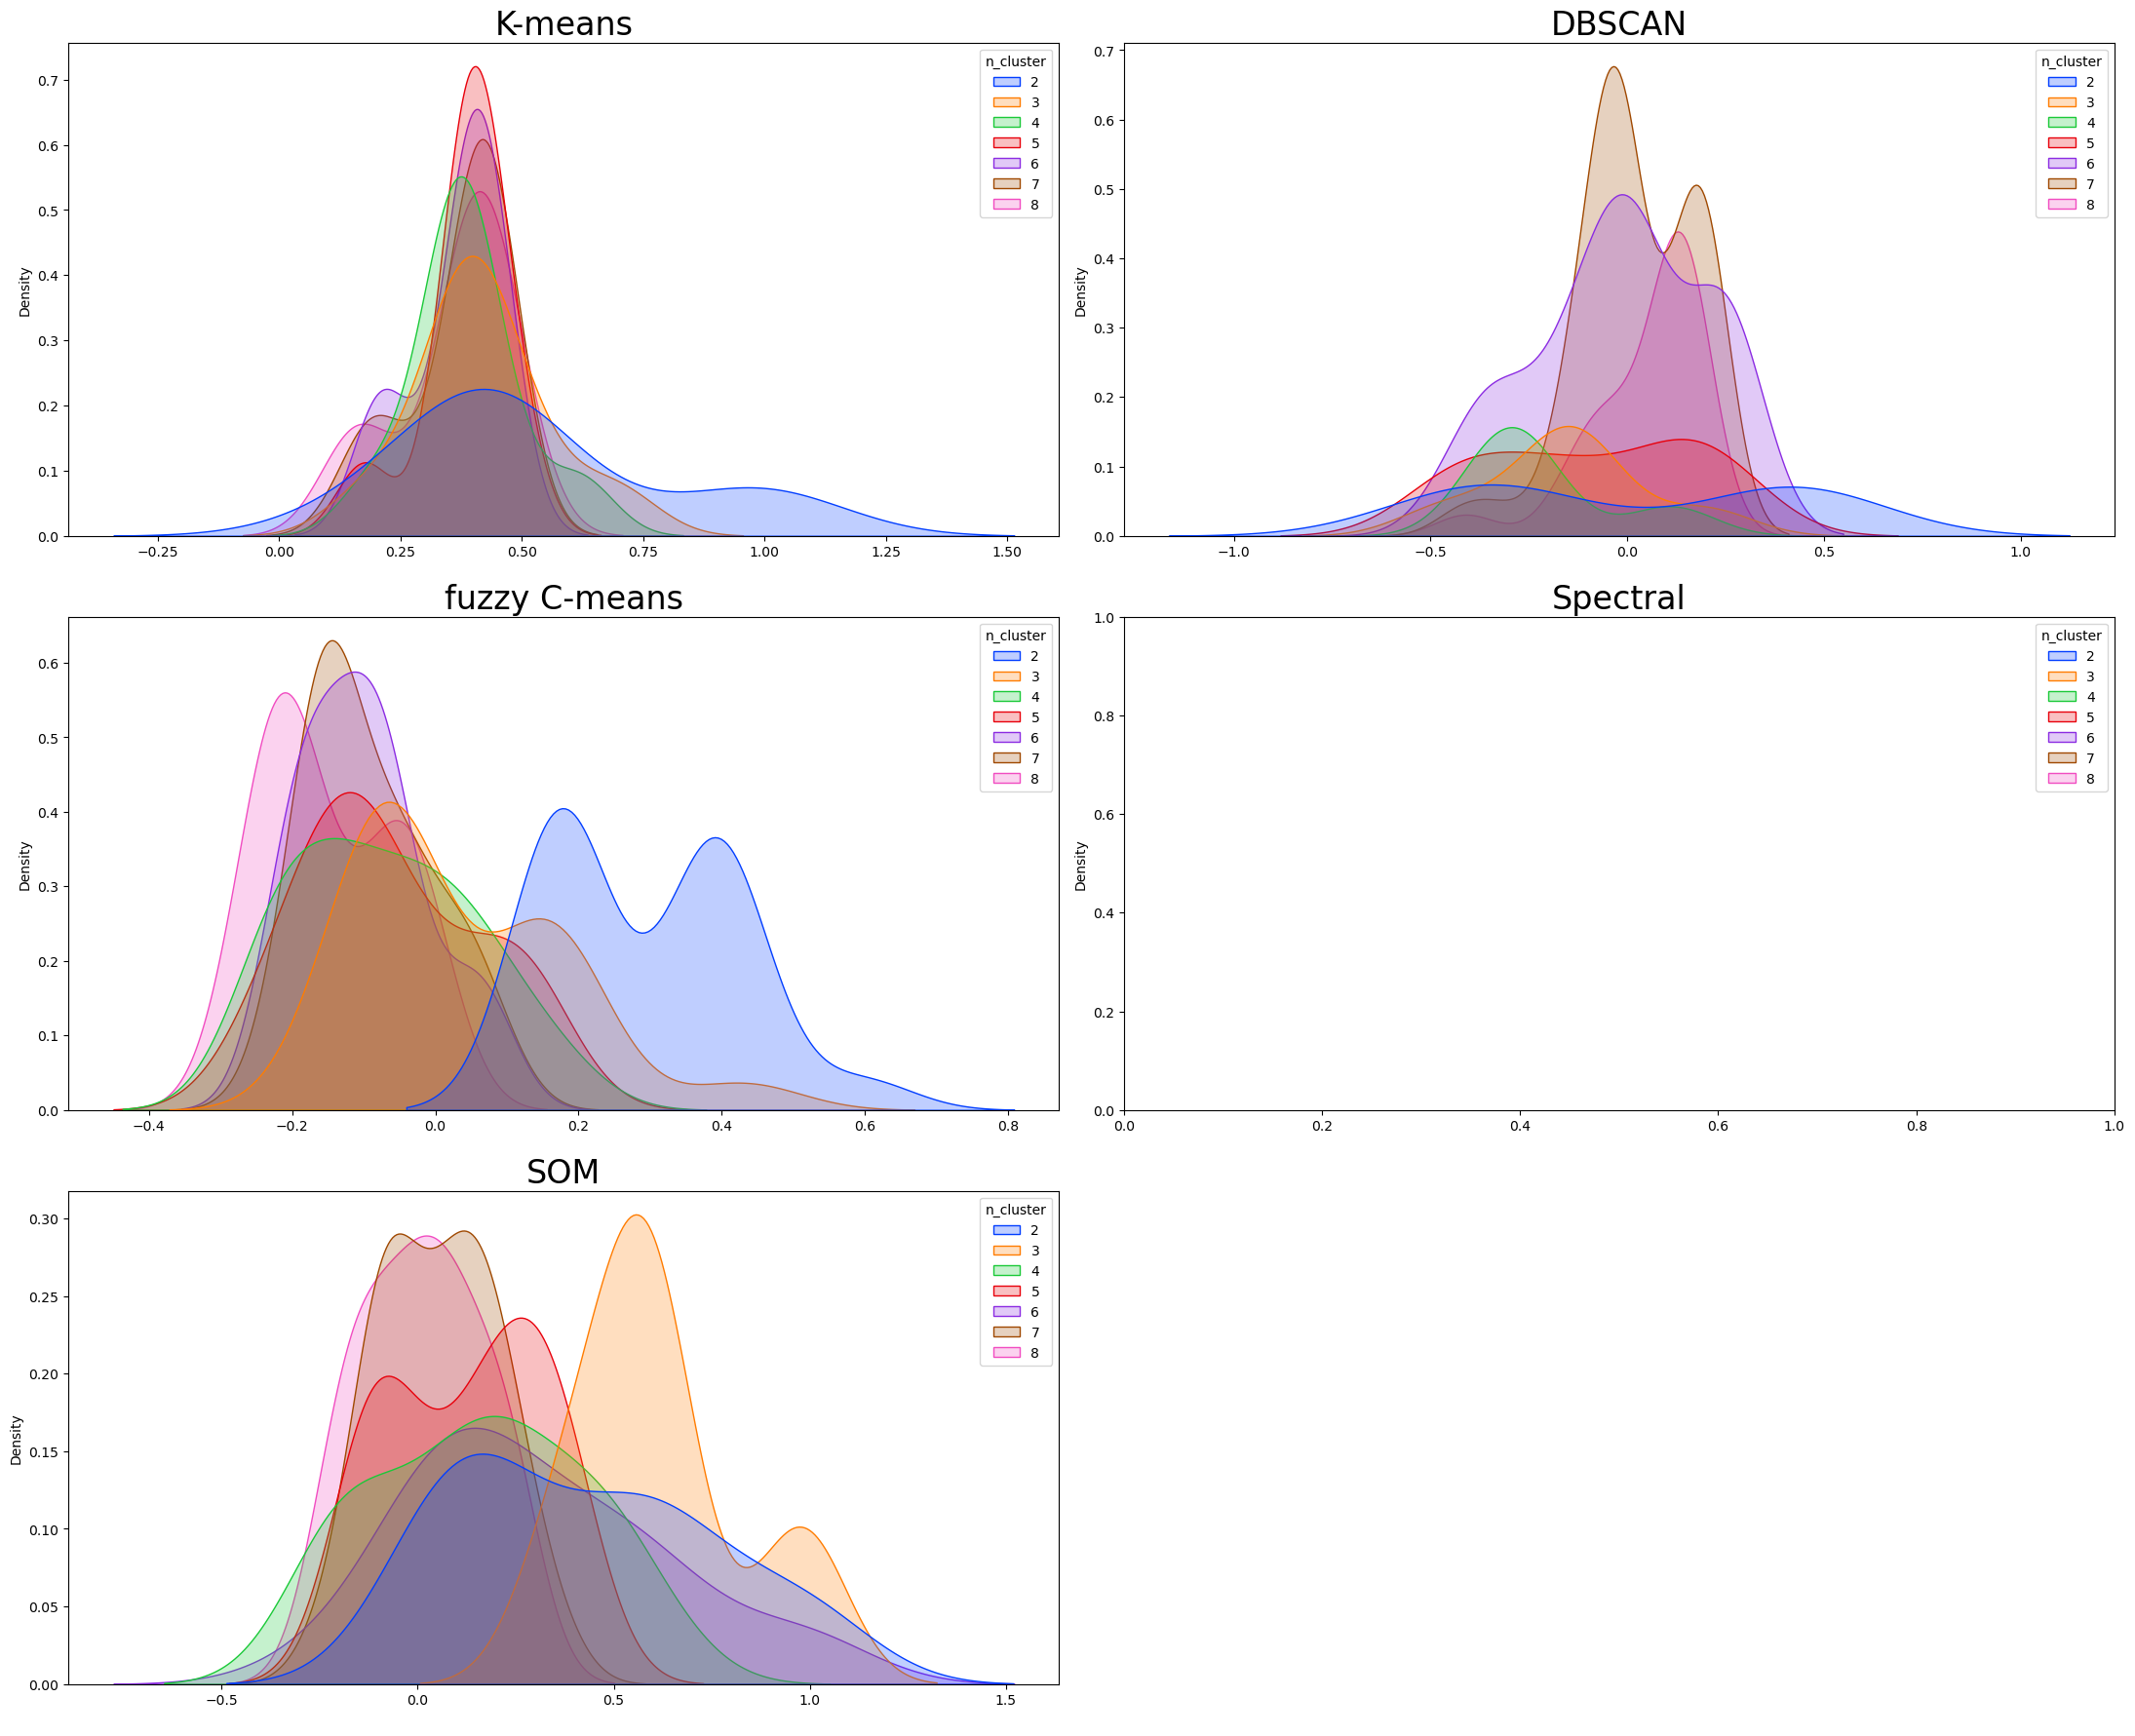

In [422]:
plot_metric_distr(df_total_notes, 'silhouette_score', num_clusters = [2,3,4,5,6,7,8])

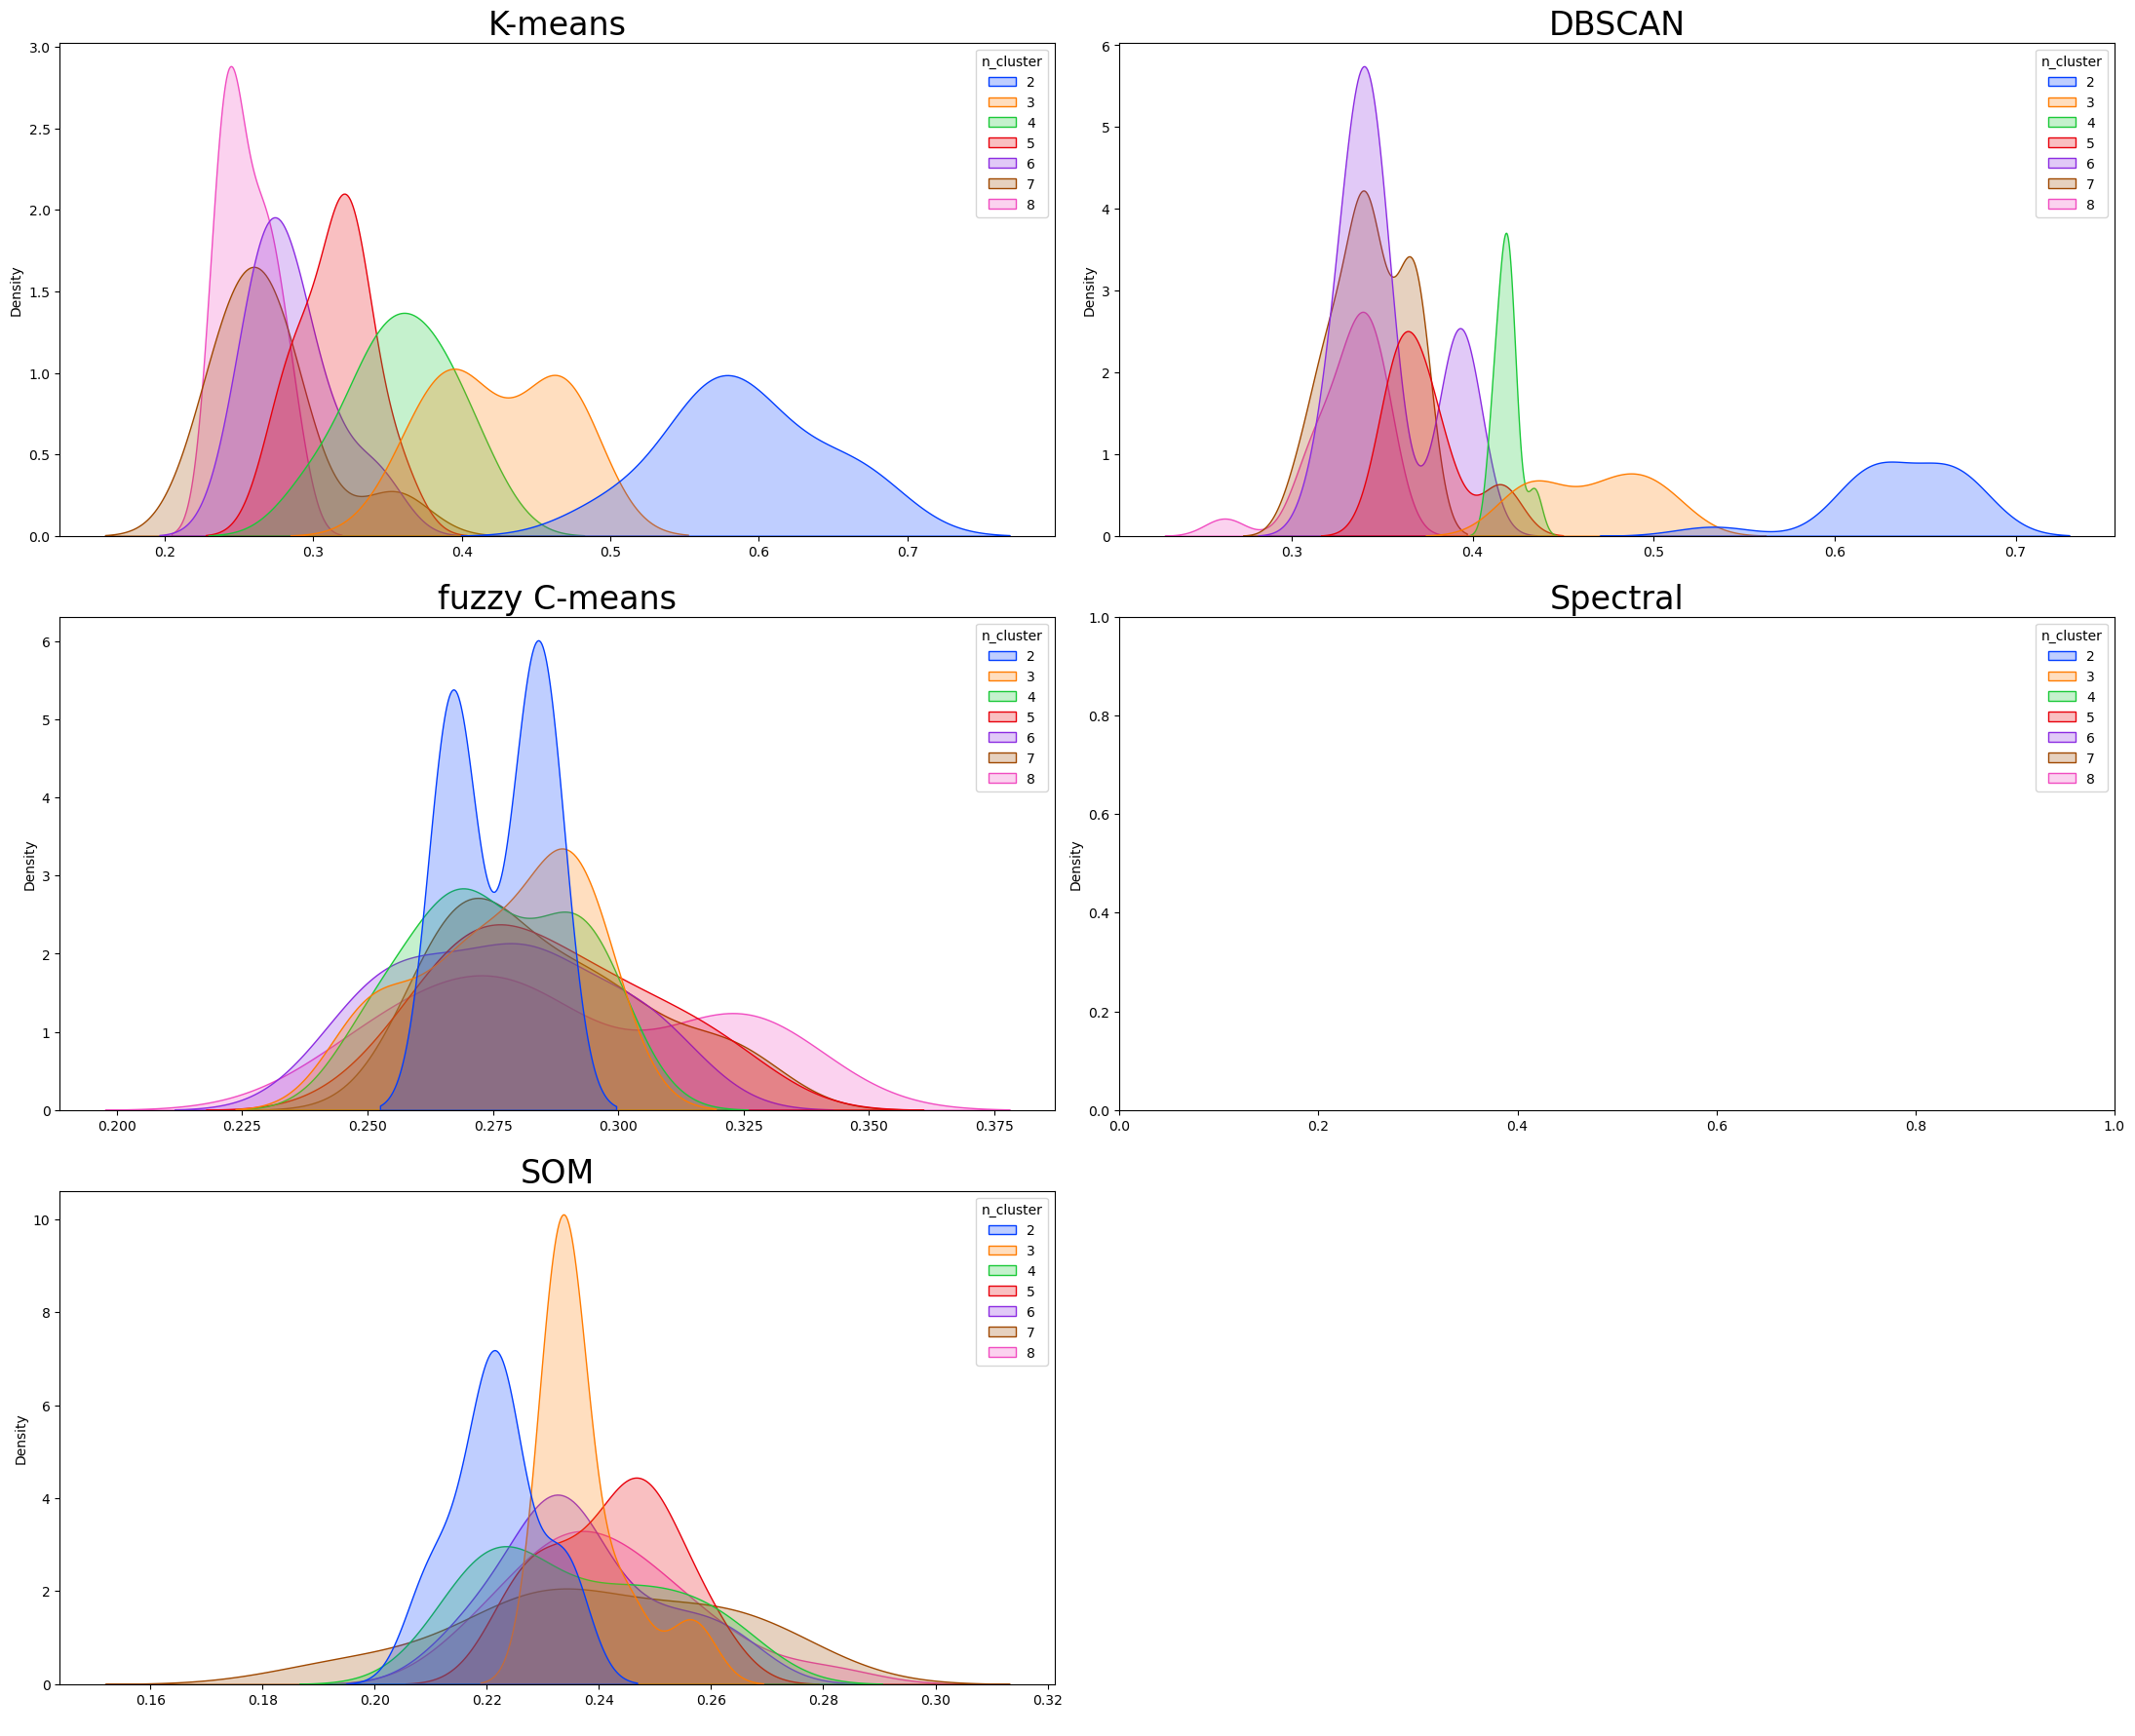

In [423]:
plot_metric_distr(df_total_notes, 'f1_bcubed', num_clusters = [2,3,4,5,6,7,8])

### 4 кластера

In [ ]:
# 4 кластера
# самые лучшие показатели bcubed у DBSCAN
# K-means и SOM - лучшие показатели силуэта
# K-means - лучший CH скор
# K-means - лучший DB

In [431]:
n_cluster = 4
df_total_notes[(df_total_notes['prc_distributed'].apply(lambda x: (1 not in x) and (0.9 not in x))) 
               & df_total_notes['n_cluster'].isin([n_cluster]) 
              ].sort_values(by = 'davies_bouldin', ascending = False)

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed,m,sigma_elast,learnig_rate
30,SOM,True,4,True,NaN,NaN,3.131132,20.918449,0.099187,0.218042,"[0.7, 0.3]",NaN,50.0,1.0
29,fuzzy C-means,True,4,True,NaN,NaN,3.108669,23.702362,0.053548,0.265971,"[0.3, 0.3, 0.2, 0.1]",82.0,NaN,NaN
25,SOM,False,4,True,NaN,NaN,3.070227,2.325122,-0.212290,0.213952,"[0.4, 0.3, 0.2, 0.1]",NaN,5.0,0.5
28,fuzzy C-means,True,4,True,NaN,NaN,3.068034,24.256118,0.057115,0.263806,"[0.3, 0.3, 0.2, 0.1]",72.0,NaN,NaN
21,fuzzy C-means,True,4,True,NaN,NaN,3.010282,20.100649,0.123852,0.295828,"[0.5, 0.4, 0.1, 0.0]",2.0,NaN,NaN
22,fuzzy C-means,False,4,True,NaN,NaN,2.802543,2.686154,-0.134244,0.272059,"[0.7, 0.3, 0.0, 0.0]",12.0,NaN,NaN
24,DBSCAN,False,4,True,None,NaN,2.775070,0.465138,-0.258594,0.417856,"[0.6, 0.3, 0.0, 0.0, 0.0]",NaN,NaN,NaN
25,DBSCAN,False,4,True,None,NaN,2.775070,0.465138,-0.258594,0.417856,"[0.6, 0.3, 0.0, 0.0, 0.0]",NaN,NaN,NaN
26,DBSCAN,False,4,True,None,NaN,2.774052,0.473019,-0.255959,0.410510,"[0.6, 0.3, 0.0, 0.0, 0.0]",NaN,NaN,NaN
30,fuzzy C-means,True,4,True,NaN,NaN,2.739060,22.049767,0.063633,0.260780,"[0.4, 0.3, 0.2, 0.1]",92.0,NaN,NaN


In [433]:
plot_metric_distr(df_total_notes, 'davies_bouldin', num_clusters = [4])

In [436]:
# выбираем среди K-means
n_cluster = 4
df_total_notes[(df_total_notes['prc_distributed'].apply(lambda x: (1 not in x) and (0.9 not in x))) 
               & df_total_notes['n_cluster'].isin([n_cluster]) 
               & (df_total_notes['clusterng'] == 'K-means')
              ].sort_values(by = 'f1_bcubed', ascending = False)

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed,m,sigma_elast,learnig_rate
3,K-means,True,4,True,tsne,NaN,1.455166,41.260839,0.198946,0.414122,"[0.6, 0.3, 0.1, 0.0]",NaN,NaN,NaN
3,K-means,True,4,False,pca,NaN,0.690283,214.761786,0.457882,0.392868,"[0.6, 0.2, 0.2, 0.0]",NaN,NaN,NaN
3,K-means,False,4,False,pca,NaN,0.371134,14334.942741,0.617488,0.382802,"[0.8, 0.2, 0.0, 0.0]",NaN,NaN,NaN
3,K-means,True,4,False,tsne,40.0,1.091339,339.206499,0.356270,0.369098,"[0.3, 0.3, 0.2, 0.2]",NaN,NaN,NaN
3,K-means,False,4,True,tsne,NaN,0.947918,4134.044130,0.335918,0.363199,"[0.7, 0.2, 0.1, 0.0]",NaN,NaN,NaN
3,K-means,True,4,False,tsne,10.0,0.811224,312.677752,0.409782,0.347421,"[0.3, 0.3, 0.2, 0.2]",NaN,NaN,NaN
3,K-means,True,4,False,tsne,20.0,0.931234,358.717275,0.385001,0.340038,"[0.3, 0.2, 0.2, 0.2]",NaN,NaN,NaN
3,K-means,True,4,False,tsne,30.0,0.890575,313.391024,0.360325,0.330111,"[0.3, 0.3, 0.2, 0.2]",NaN,NaN,NaN
3,K-means,False,4,False,tsne,40.0,0.905111,332.446773,0.364518,0.297624,"[0.3, 0.3, 0.2, 0.2]",NaN,NaN,NaN


In [439]:
# Лучшая модель для 4 кластеров с точки зрения метрик
n_cluster = 4
df_total_notes[(df_total_notes['prc_distributed'].apply(lambda x: (1 not in x) and (0.9 not in x))) 
               & df_total_notes['n_cluster'].isin([n_cluster]) 
               & (df_total_notes['clusterng'] == 'K-means')
              ].sort_values(by = 'f1_bcubed', ascending = False).iloc[2]

clusterng                                   K-means
scaling                                       False
n_cluster                                         4
clustering_before_dimreduce                   False
pca_or_tsne                                     pca
perplexity                                      NaN
davies_bouldin                             0.371134
calinski_harabasz_score                14334.942741
silhouette_score                           0.617488
f1_bcubed                                  0.382802
prc_distributed                [0.8, 0.2, 0.0, 0.0]
m                                               NaN
sigma_elast                                     NaN
learnig_rate                                    NaN
Name: 3, dtype: object

In [27]:
from clustering_functions import K_means_cluster
k_means = K_means_cluster(features_table = X,
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [4], 
                          bank_name_column = bank_names, 
                          scaling = False,
                         pca_or_tsne = 'pca',
                        clustering_before_dimreduce = False,
                          perplexity = None,
                          plot=True)
k_means.k_means_clustering()

In [28]:
k_means.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,False,4,False,pca,None,0.440822,14336.937375,0.596538,0.367426,"[0.7, 0.2, 0.0, 0.0]"


In [29]:
names_list1, dataframe1 = k_means.compute_cluster_stats(list_index = 0, cluster_index = 0)
names_list2, dataframe2 = k_means.compute_cluster_stats(list_index = 0, cluster_index = 1)
names_list3, dataframe3 = k_means.compute_cluster_stats(list_index = 0, cluster_index = 2)
names_list4, dataframe4 = k_means.compute_cluster_stats(list_index = 0, cluster_index = 3)

Всего кластеров 4
Банков попало в кластер: 77
Всего кластеров 4
Банков попало в кластер: 1
Всего кластеров 4
Банков попало в кластер: 253
Всего кластеров 4
Банков попало в кластер: 8


In [30]:
df_compare = pd.DataFrame()
total_names_list = []
for i in range(4):
    names_list_i, dataframe_i = k_means.compute_cluster_stats(list_index = 0, cluster_index = i)
    dataframe_i = dataframe_i.rename(columns = {'mean' : f'mean_{i}', 
                                                'std' : f'std_{i}', 
                                                'min' : f'min_{i}', 
                                                'max' : f'max_{i}'})
    
    df_compare = pd.concat([df_compare, dataframe_i[[f'mean_{i}', 
                                                     f'std_{i}', 
                                                     f'min_{i}', 
                                                     f'max_{i}']]], axis=1) 
    total_names_list.append(names_list_i)

Всего кластеров 4
Банков попало в кластер: 77
Всего кластеров 4
Банков попало в кластер: 1
Всего кластеров 4
Банков попало в кластер: 253
Всего кластеров 4
Банков попало в кластер: 8


<Axes: >

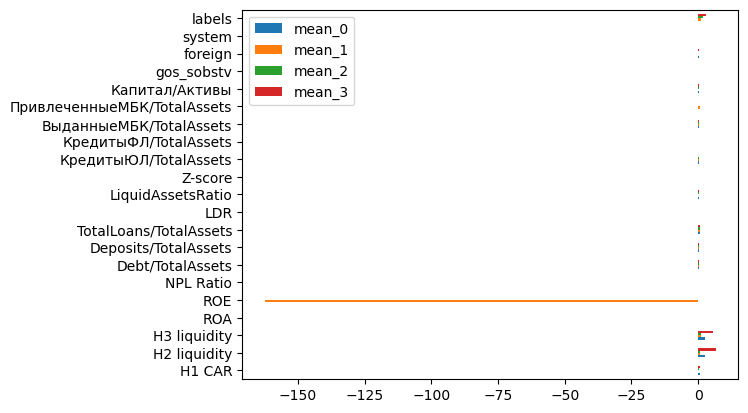

In [35]:
_df = pd.DataFrame(df_compare,columns=['mean_0', 'mean_1','mean_2','mean_3',])
_df.plot.barh()

<Axes: >

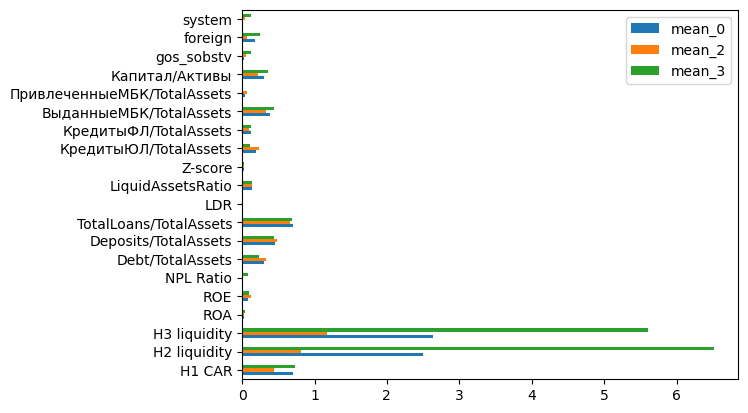

In [37]:
_df = pd.DataFrame(df_compare.drop(index = 'labels'),columns=['mean_0','mean_2','mean_3',])
_df.plot.barh()

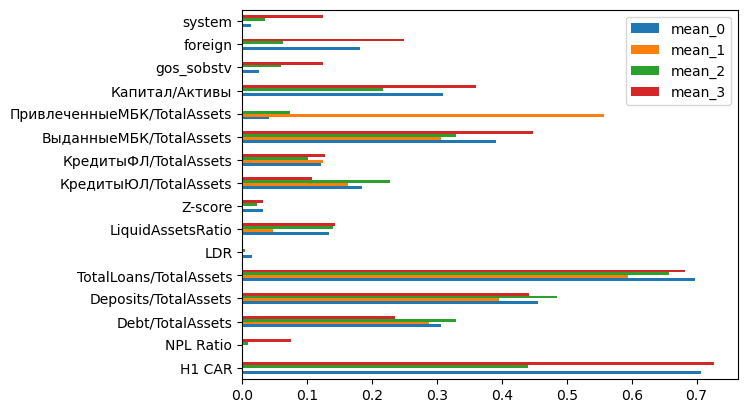

In [38]:
_df = pd.DataFrame(df_compare.drop(index = ['labels', 'Н2 liquidity', 'Н3 liquidity', 'ROE', 'ROA']),
                   columns=['mean_0','mean_1', 'mean_2','mean_3'])
_df.plot.barh();

In [40]:
len(total_names_list[2])

253

In [98]:
total_names_list[2]

### Так как во 2й кластер попало слишком большое число кластеров - сделаем для него nested K-means

In [43]:
new_labels = k_means.labels

In [55]:
new_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 0, 3, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1,
       0, 0, 2, 0, 3, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2,
       2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 0,
       3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,

In [160]:
from clustering_functions import K_means_cluster
k_means_1 = K_means_cluster(features_table = X[new_labels == 2],
                          df_bcubed_table = df_bcubed_table,
                          num_clusters = [3], 
                          bank_name_column = x_2023[new_labels == 2]['bank_name'], 
                          scaling = False,
                         pca_or_tsne = 'pca',
                        clustering_before_dimreduce = False,
                          perplexity = None,
                          plot=True)
k_means_1.k_means_clustering()

In [161]:
k_means_1.df_notes

,clusterng,scaling,n_cluster,clustering_before_dimreduce,pca_or_tsne,perplexity,davies_bouldin,calinski_harabasz_score,silhouette_score,f1_bcubed,prc_distributed
1,K-means,False,3,False,pca,None,0.713176,173.934568,0.636009,cannot_compute,"[0.9, 0.1, 0.0]"


In [162]:
df_compare2 = pd.DataFrame()
total_names_list2 = []
for i in range(3):
    names_list_i, dataframe_i = k_means_1.compute_cluster_stats(list_index = 0, cluster_index = i)
    dataframe_i = dataframe_i.rename(columns = {'mean' : f'mean_{i+4}', 
                                                'std' : f'std_{i+4}', 
                                                'min' : f'min_{i+4}', 
                                                'max' : f'max_{i+4}'})
    
    df_compare2 = pd.concat([df_compare2, dataframe_i[[f'mean_{i+4}', 
                                                     f'std_{i+4}', 
                                                     f'min_{i+4}', 
                                                     f'max_{i+4}']]], axis=1) 
    total_names_list2.append(names_list_i)

Всего кластеров 3
Банков попало в кластер: 227
Всего кластеров 3
Банков попало в кластер: 20
Всего кластеров 3
Банков попало в кластер: 6


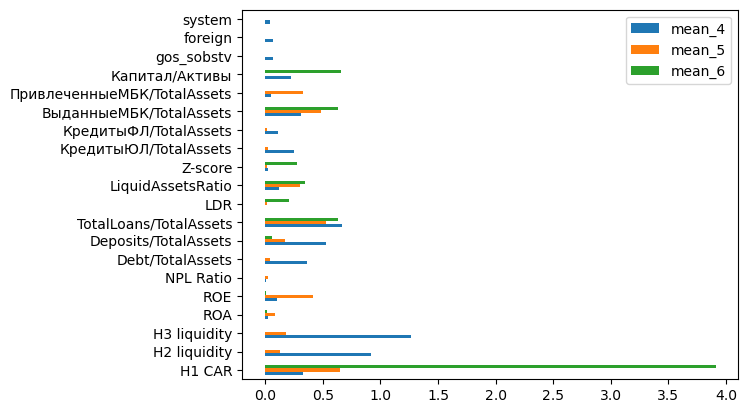

In [164]:
_df = pd.DataFrame(df_compare2.drop(index = ['labels']),
                   columns=['mean_4','mean_5', 'mean_6'])
_df.plot.barh();

In [167]:
df_compare3 = pd.concat([df_compare, df_compare2], axis = 1)

In [184]:
total_names_list3 = total_names_list + total_names_list2

In [188]:
total_names_list3.pop(2)

In [187]:
len(total_names_list3)

6

In [191]:
df_compare3 = df_compare3.drop(columns = ['mean_2', 'std_2', 'min_2', 'max_2'])

<Axes: >

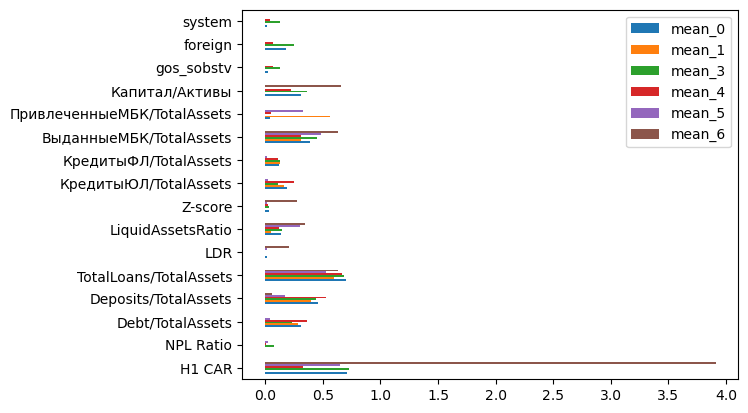

In [205]:
_df = pd.DataFrame(df_compare3.drop(index = ['labels','Н2 liquidity', 'Н3 liquidity', 'ROE', 'ROA']),
                   columns=['mean_0','mean_1','mean_3','mean_4', 'mean_5', 'mean_6'])

_df.plot.barh()

In [228]:
len(total_names_list3[0])

77

In [229]:
total_names_list3[0]

array(['ЮниКредит Банк', 'Ситибанк', 'РНКБ', 'Хоум Банк', 'ББР Банк',
       'Банк Синара (СКБ-банк)', 'Инвестторгбанк', '«Кубань Кредит»',
       'Локо-Банк', 'Банк Интеза', 'Примсоцбанк', 'БКС Банк',
       'Банк «Центр-инвест»', 'ИНГ Банк', 'Авто Финанс Банк',
       'Челябинвестбанк', 'Тимер Банк', 'МС Банк Рус', 'Мидзухо Банк',
       'SBI Банк', 'Энерготрансбанк', '«Банк Кредит Свисс (Москва)»',
       'Урал ФД', 'БыстроБанк', '«ТАТСОЦБАНК»', 'Прио-Внешторгбанк',
       'SEB', 'Норвик Банк', 'Банк «ОРЕНБУРГ»', 'Джей энд Ти Банк',
       '«Развитие-Столица»', 'Банк «Пойдём!»', 'Витабанк',
       '«Гарант-Инвест»', 'Банк «Снежинский»',
       'Хакасский муниципальный банк', 'Томскпромстройбанк', 'Новобанк',
       'Ставропольпромстройбанк', 'Долинск', 'Газтрансбанк',
       'СТРОЙЛЕСБАНК', '«Универсальный фондовый банк»', 'Братский АНКБ',
       'Кубаньторгбанк', 'Тендербанк', 'БСТ-Банк', 'ПроБанк',
       'Банк «Заречье»', 'Банк «Приобье»', 'Банк «Викинг»',
       'Банк «Соколовcк

In [210]:
labels2 = k_means_1.labels

In [213]:
new_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 0, 3, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1,
       0, 0, 2, 0, 3, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2,
       2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 0,
       3, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,

In [214]:
labels2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       2, 0, 2, 1, 0, 1, 2, 2, 2, 1, 2])

In [219]:
df = x_2023[x_2023.columns]

df['labels_c1'] = new_labels
df['labels_c2'] = None
df.loc[df['labels_c1'] == 2, 'labels_c2'] = labels2

df['labels_c3'] = None
df.loc[df['labels_c1'] == 0, 'labels_c3'] = 1
df.loc[df['labels_c1'] == 1, 'labels_c3'] = 2
df.loc[df['labels_c1'] == 3, 'labels_c3'] = 3

df.loc[df['labels_c2'] == 0, 'labels_c3'] = 4
df.loc[df['labels_c2'] == 1, 'labels_c3'] = 5
df.loc[df['labels_c2'] == 2, 'labels_c3'] = 6

In [227]:
df[df['labels_c3'] == 1]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system,labels_c1,labels_c2,labels_c3
13,ЮниКредит Банк,0.4502,2.9034,5.0753,0.046012,0.191646,0.003532,0.242454,0.528763,0.668284,0.000269,0.190934,0.014567,0.182250,0.060204,0.425829,0.011873,0.240090,20.935243,0,1,1,0,None,1
19,Ситибанк,0.7514,2.2537,2.2491,0.020380,0.112973,0.000405,0.019075,0.029981,0.225345,0.001598,0.697569,0.055536,0.011507,0.007568,0.206270,0.019145,0.180396,20.156265,0,1,0,0,None,1
23,РНКБ,0.1978,1.3274,2.4637,0.029137,0.151533,0.000440,0.633194,0.452494,0.717504,0.000337,0.068791,0.008156,0.342898,0.290296,0.084310,0.007644,0.192281,19.899686,1,0,0,0,None,1
28,Хоум Банк,0.1738,2.6477,1.3640,0.051763,0.240345,0.001123,0.718611,0.428422,0.806949,0.000400,0.048827,0.006153,0.050588,0.668024,0.088338,0.059071,0.215370,19.479480,0,0,0,0,None,1
32,ББР Банк,0.1578,1.9861,2.1725,0.014858,0.206411,0.000081,0.413932,0.692895,0.830193,0.000255,0.084477,0.010244,0.394349,0.019583,0.416261,0.000000,0.071981,19.218384,0,0,0,0,None,1
38,Банк Синара (СКБ-банк),0.1404,2.0436,3.8654,0.013703,0.253697,0.003659,0.040553,0.495430,0.323922,0.000139,0.170196,0.005007,0.020450,0.020103,0.283369,0.263212,0.054013,18.998731,0,0,0,0,None,1
39,Инвестторгбанк,0.0000,3.9322,3.9462,0.000106,-0.001105,0.044221,0.343500,0.850419,0.409012,0.000102,0.038518,0.001040,0.188800,0.154700,0.065512,0.232782,-0.095838,18.990550,0,0,0,0,None,1
40,«Кубань Кредит»,0.1404,0.9727,4.7301,0.014945,0.138674,0.000023,0.577724,0.729589,0.630195,0.000184,0.051617,0.013209,0.387070,0.190654,0.052471,0.023494,0.107768,18.958694,0,0,0,0,None,1
41,Локо-Банк,0.1861,3.9600,3.1107,0.057841,0.363542,0.000278,0.409609,0.454888,0.462797,0.000216,0.046750,0.006902,0.017298,0.392312,0.053187,0.242782,0.159103,18.925343,0,0,0,0,None,1
44,Банк Интеза,0.5874,2.6946,1.4463,0.036885,0.243793,0.001482,0.109509,0.509436,0.621287,0.000259,0.288389,0.019408,0.105594,0.003915,0.511778,0.218943,0.151297,18.775835,0,1,0,0,None,1


In [233]:
df = df.drop(columns = ['labels_c1', 'labels_c2']).rename(columns = {'labels_c3' : 'labels'})

In [235]:
df.to_excel('kmeans_c6.xlsx', index = False)

### Банки с отозванной лицензией

In [236]:
df_l = pd.read_excel('full_dfs/license_revoke_df.xlsx')

In [237]:
df_l.head()

,банк,причина,дата отзыва
0,Банк Стрела,отозв.,2024-03-22
1,Банк «Гефест»,отозв.,2024-02-28
2,КИВИ Банк,отозв.,2024-02-21
3,ЮСиЭс,ликв.,2024-02-02
4,СМП Банк,ликв.,2024-01-01


In [238]:
x_2023[x_2023['bank_name'].isin(df_l['банк'])] # банки, у которых отозвали лицензию

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system
64,КИВИ Банк,0.1661,0.7263,1.1801,0.102848,0.311691,0.000614,0.087694,0.242029,0.383336,0.000337,0.170408,0.003851,0.087693,0.000001,0.295642,0.0,0.329968,18.122731,0,0,0
258,Банк Стрела,2.3777,NaN,2.1391,0.284312,0.538621,0.000000,0.000000,0.000135,0.635306,1.000000,0.279893,0.007433,0.000000,0.000000,0.635306,0.0,0.527852,14.108404,0,0,0
277,Банк «Гефест»,0.5895,NaN,1.3764,-0.038356,-0.086233,0.000892,0.386048,0.404775,0.780706,0.000410,0.052936,0.014359,0.383640,0.002408,0.394658,0.0,0.444797,13.457894,0,0,0
330,ЮСиЭс,3.6968,NaN,NaN,-0.023114,-0.023683,0.000000,0.000000,0.000000,0.000000,NaN,0.974899,NaN,0.000000,0.000000,0.000000,0.0,0.975964,13.012178,0,0,0


In [240]:
df[df['Z-score'] < df['Z-score'].quantile(0.1)]

,bank_name,Н1 CAR,Н2 liquidity,Н3 liquidity,ROA,ROE,NPL Ratio,Debt/TotalAssets,Deposits/TotalAssets,TotalLoans/TotalAssets,LDR,LiquidAssetsRatio,Z-score,КредитыЮЛ/TotalAssets,КредитыФЛ/TotalAssets,ВыданныеМБК/TotalAssets,ПривлеченныеМБК/TotalAssets,Капитал/Активы,log_TotalAssets,gos_sobstv,foreign,system,labels
24,Уральский банк реконструкции и развития (УБРиР),0.0886,1.0659,1.7754,-0.033055,-0.572836,0.000498,0.378255,0.640746,0.670726,2.225121e-04,0.099444,0.002509,0.190261,0.187995,0.292471,0.038238,0.057703,19.713790,0,0,0,4
30,«Траст»,0.0000,0.3994,0.7723,0.328926,-0.063047,0.059865,0.156244,0.005740,0.223759,8.285890e-03,0.005143,0.001944,0.156184,0.000060,0.067515,5.277712,-5.217186,19.395601,0,0,0,5
39,Инвестторгбанк,0.0000,3.9322,3.9462,0.000106,-0.001105,0.044221,0.343500,0.850419,0.409012,1.022343e-04,0.038518,0.001040,0.188800,0.154700,0.065512,0.232782,-0.095838,18.990550,0,0,0,1
43,Газэнергобанк,0.0002,0.7302,1.0733,-0.021013,-162.453643,0.001806,0.287230,0.395945,0.594308,3.190589e-04,0.048238,0.000000,0.162568,0.124662,0.307077,0.557946,0.000129,18.791730,0,0,0,2
48,Ренессанс Банк,0.1092,8.7248,4.8419,-0.012462,-0.102562,0.001447,0.715356,0.546848,0.754812,2.934036e-04,0.044661,0.003214,0.001854,0.713502,0.039455,0.000000,0.121504,18.709802,0,0,0,3
50,Таврический Банк,0.0000,1.1871,0.5366,0.085155,-0.316912,1.000000,0.028932,0.649379,0.028961,9.480060e-06,0.033815,0.002202,0.023142,0.005790,0.000029,0.657784,-0.268702,18.648918,0,0,0,4
57,Национальный Резервный Банк,0.3011,0.7658,1.2258,0.035922,0.355875,0.000012,0.028584,0.197232,0.318587,3.433565e-04,0.348028,0.003149,0.027818,0.000766,0.290003,0.164104,0.100941,18.381633,0,0,0,4
64,КИВИ Банк,0.1661,0.7263,1.1801,0.102848,0.311691,0.000614,0.087694,0.242029,0.383336,3.366707e-04,0.170408,0.003851,0.087693,0.000001,0.295642,0.000000,0.329968,18.122731,0,0,0,4
66,ВУЗ-банк,0.0000,0.3157,0.5590,-0.241509,0.804715,0.006033,0.624657,0.091934,0.653883,1.511884e-03,0.028992,0.000261,0.283661,0.340996,0.029226,1.305042,-0.300117,18.080130,0,0,0,5
71,Банк «ЦентроКредит»,0.3877,1.2559,1.5929,0.193236,0.437174,0.000695,0.552360,0.137317,0.785008,1.215191e-03,0.043462,0.003549,0.545050,0.007311,0.232648,0.012127,0.442013,18.004708,0,0,0,4
